In [1]:
# Command to reload all modules before executing the code
%load_ext autoreload 
%autoreload 2

# Imports

In [2]:
# ML libraries
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Utils
import os
import sys
from collections import defaultdict
from tqdm import tqdm
import warnings
from typing import List, Dict, Any, Tuple, Union, Optional, Callable, TypeVar
# Project modules
pass

warnings.filterwarnings('ignore')

C:\Users\timot\AppData\Local\Temp\ipykernel_13948\3779753175.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load data and group columns

Much of the features are given in the form of statistical aggregate (e.g. average, sum, std, last 5 matchs average). We group the features that correspond to the same statistic (metric). We call :
- `metric` the name of the statistic (e.g. HOME_TEAM_SHOTS_OUTSIDEBOX, HOME_TEAM_INJURIES, AWAY_TEAM_ATTACKS) even if they are not aggregated (like HOME_TEAM_NAME, AWAY_TEAM_ID, PLAYER_PENALTIES_SAVED )
- `aggregate function` the name of the aggregation function, among ['season_sum', 'season_average', 'season_std', '5_last_match_sum', '5_last_match_average', '5_last_match_std']
- `column` or `feature` the name of the concatenated column (e.g. HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum, HOME_TEAM_SHOTS_OUTSIDEBOX_season_average, HOME_TEAM_SHOTS_OUTSIDEBOX_5_last_match_sum, HOME_TEAM_SHOTS_OUTSIDEBOX_5_last_match_average)

We will later plot the distribution of features grouped by metric. Note they are two kind of metrics (teammetrics and playermetrics) and therefore two kind of features/columns and that some special metric are not aggregated and still called metric.

In [3]:
# Load data
from src.data_loading import load_dataframe_teamfeatures
df_teamfeatures_train = load_dataframe_teamfeatures(dataset_prefix='train')
df_teamfeatures_train.head()

HOME_ID     HOME_LEAGUE           HOME_TEAM_NAME  \
0        0         Ligue 1                 Toulouse   
1        1         Ligue 2                    Brest   
2        2         Serie A                Sampdoria   
3        3      League One            Coventry City   
4        4  Premier League  Wolverhampton Wanderers   

   HOME_TEAM_SHOTS_TOTAL_season_sum  HOME_TEAM_SHOTS_INSIDEBOX_season_sum  \
0                               3.0                                   2.0   
1                               6.0                                   8.0   
2                               4.0                                   2.0   
3                               7.0                                   5.0   
4                               3.0                                   3.0   

   HOME_TEAM_SHOTS_OFF_TARGET_season_sum  \
0                                    5.0   
1                                    3.0   
2                                    5.0   
3                                    5.0   
4                                    2.0   

   HOME_TEAM_SHOTS_ON_TARGET_season_sum  \
0                                   2.0   
1                                   6.0   
2                                   2.0   
3                                   6.0   
4                                   3.0   

   HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum  HOME_TEAM_PASSES_season_sum  \
0                                    1.0                          2.0   
1                                    5.0                          8.0   
2                                    8.0                          1.0   
3                                    6.0                          9.0   
4                                    4.0                          4.0   

   HOME_TEAM_SUCCESSFUL_PASSES_season_sum  ...  \
0                                     2.0  ...   
1                                     7.0  ...   
2                                     1.0  ...   
3                                     9.0  ...   
4                                     3.0  ...   

   AWAY_TEAM_YELLOWCARDS_5_last_match_std  \
0                                     5.0   
1                                     0.0   
2                                     6.0   
3                                     0.0   
4                                     1.0   

   AWAY_TEAM_REDCARDS_5_last_match_std  AWAY_TEAM_OFFSIDES_5_last_match_std  \
0                                  5.0                                  4.0   
1                                  0.0                                  3.0   
2                                 10.0                                  4.0   
3                                  0.0                                  1.0   
4                                  0.0                                  4.0   

   AWAY_TEAM_ATTACKS_5_last_match_std  AWAY_TEAM_PENALTIES_5_last_match_std  \
0                                 0.0                                   6.0   
1                                 1.0                                   8.0   
2                                 4.0                                   0.0   
3                                 2.0                                   0.0   
4                                 4.0                                   9.0   

   AWAY_TEAM_SUBSTITUTIONS_5_last_match_std  \
0                                       8.0   
1                                       4.0   
2                                       8.0   
3                                       5.0   
4                                       4.0   

   AWAY_TEAM_BALL_SAFE_5_last_match_std  \
0                                   4.0   
1                                  10.0   
2                                   3.0   
3                                   6.0   
4                                   1.0   

   AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std  \
0                                           3.0   
1                                           0.0   
2                            

In [5]:
# Identify dataset shape and columns
n, d = df_teamfeatures_train.shape
print(f"Data shape: {n} rows, {d} columns")
print(f"Column names: {df_teamfeatures_train.columns}")

# Group column names by metrics, i.e. columns that have the same prefix in capital letters,
# ie colmun_name = TEAM_SHOTS_INSIDEBOX_season_sum -> metric = TEAM_SHOTS_INSIDEBOX
from src.data_analysis import get_metrics_names_to_fn_names
teammetrics_names_to_fn_names = get_metrics_names_to_fn_names(df_teamfeatures_train)

for metric_name, aggregate_function_names in teammetrics_names_to_fn_names.items():
    print(f"Metric name: {metric_name} for the {len(aggregate_function_names)} aggregate functions: {aggregate_function_names}")
print(f"Number of metrics: {len(teammetrics_names_to_fn_names)}")
print(f"Number of columns after grouping by metrics: {sum([len(aggregate_function_names) for aggregate_function_names in teammetrics_names_to_fn_names.values()])}")

Data shape: 12303 rows, 286 columns
Column names: Index(['HOME_ID', 'HOME_LEAGUE', 'HOME_TEAM_NAME',
       'HOME_TEAM_SHOTS_TOTAL_season_sum',
       'HOME_TEAM_SHOTS_INSIDEBOX_season_sum',
       'HOME_TEAM_SHOTS_OFF_TARGET_season_sum',
       'HOME_TEAM_SHOTS_ON_TARGET_season_sum',
       'HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum', 'HOME_TEAM_PASSES_season_sum',
       'HOME_TEAM_SUCCESSFUL_PASSES_season_sum',
       ...
       'AWAY_TEAM_YELLOWCARDS_5_last_match_std',
       'AWAY_TEAM_REDCARDS_5_last_match_std',
       'AWAY_TEAM_OFFSIDES_5_last_match_std',
       'AWAY_TEAM_ATTACKS_5_last_match_std',
       'AWAY_TEAM_PENALTIES_5_last_match_std',
       'AWAY_TEAM_SUBSTITUTIONS_5_last_match_std',
       'AWAY_TEAM_BALL_SAFE_5_last_match_std',
       'AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std',
       'AWAY_TEAM_INJURIES_5_last_match_std',
       'AWAY_TEAM_GOALS_5_last_match_std'],
      dtype='object', length=286)
Metric name: HOME_ID for the 1 aggregate functions: ['']
Metric n

In [6]:
# Load labels
from src.data_loading import load_dataframe_labels
df_labels = load_dataframe_labels()
df_labels.head()

ID  HOME_WINS  DRAW  AWAY_WINS
0   0          0     0          1
1   1          0     1          0
2   2          0     0          1
3   3          1     0          0
4   4          0     1          0

In [7]:

# Load players features
from src.data_loading import load_dataframe_playersfeatures
df_playersfeatures_train_home, df_playersfeatures_train_away = load_dataframe_playersfeatures(
    dataset_prefix='train', 
    n_rows_to_load=10000,     # if unspecified, all rows are loaded but it takes like 9s
    )  
df_playersfeatures_train_home.head()


ID_team   LEAGUE TEAM_NAME    POSITION          PLAYER_NAME  \
0        0  Ligue 1  Toulouse    defender        Agustín Rogel   
1        0  Ligue 1  Toulouse    defender    Mathieu Goncalves   
2        0  Ligue 1  Toulouse  goalkeeper      Baptiste Reynet   
3        0  Ligue 1  Toulouse  midfielder  Jean-Victor Makengo   
4        0  Ligue 1  Toulouse         NaN  Efthymios Koulouris   

   PLAYER_ACCURATE_CROSSES_season_sum  PLAYER_ACCURATE_PASSES_season_sum  \
0                                 0.0                                8.0   
1                                 0.0                                7.0   
2                                 0.0                               33.0   
3                                 8.0                               27.0   
4                                 2.0                               23.0   

   PLAYER_AERIALS_WON_season_sum  PLAYER_ASSISTS_season_sum  \
0                            5.0                        0.0   
1                            4.0                        0.0   
2                            2.0                        0.0   
3                            2.0                        0.0   
4                           27.0                       14.0   

   PLAYER_BIG_CHANCES_CREATED_season_sum  ...  \
0                                    0.0  ...   
1                                    0.0  ...   
2                                    0.0  ...   
3                                    8.0  ...   
4                                    8.0  ...   

   PLAYER_STARTING_LINEUP_5_last_match_std  \
0                                      NaN   
1                                     63.0   
2                                      0.0   
3                                     63.0   
4                                     63.0   

   PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std  \
0                                          NaN   
1                                         14.0   
2                                          0.0   
3                                          0.0   
4                                         17.0   

   PLAYER_TACKLES_5_last_match_std  PLAYER_TOTAL_CROSSES_5_last_match_std  \
0                              NaN                                    NaN   
1                             13.0                                    0.0   
2                              0.0                                    0.0   
3                             13.0                                    6.0   
4                             10.0                                   13.0   

   PLAYER_TOTAL_DUELS_5_last_match_std  PLAYER_YELLOWCARDS_5_last_match_std  \
0                                  NaN                                  NaN   
1                                 36.0                                 77.0   
2                                  3.0                                  0.0   
3                                 17.0                                  0.0   
4                                 27.0                                  0.0   

   PLAYER_PUNCHES_5_last_match_std  PLAYER_LONG_BALLS_5_last_match_std  \
0                              NaN                                 NaN   
1                              NaN                                 NaN   
2                              NaN                                 NaN   
3                              NaN                                 NaN   
4                              NaN                                 NaN   

   PLAYER_LONG_BALLS_WON_5_last_match_std  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   PLAYER_SHOTS_OFF_TARGET_5_last_match_std  
0                                       NaN  
1                                       NaN  
2                                       NaN  
3                                       NaN  
4            

In [8]:
# Identify dataset shape and columns
n, d = df_playersfeatures_train_home.shape
print(f"Data shape: {n} rows, {d} columns")
print(f"Column names: {df_playersfeatures_train_home.columns}")

# Group column names by metrics, i.e. columns that have the same prefix in capital letters,
# ie colmun_name = TEAM_SHOTS_INSIDEBOX_season_sum -> metric = TEAM_SHOTS_INSIDEBOX
playermetrics_names_to_fn_names = get_metrics_names_to_fn_names(df_playersfeatures_train_home)
    
for metric_name, aggregate_function_names in playermetrics_names_to_fn_names.items():
    print(f"Metric name: {metric_name} for the {len(aggregate_function_names)} aggregate functions: {aggregate_function_names}")
print(f"Number of metrics: {len(playermetrics_names_to_fn_names)}")
print(f"Number of columns after grouping by metrics: {sum([len(aggregate_function_names) for aggregate_function_names in playermetrics_names_to_fn_names.values()])}")

Data shape: 1000 rows, 307 columns
Column names: Index(['ID_team', 'LEAGUE', 'TEAM_NAME', 'POSITION', 'PLAYER_NAME',
       'PLAYER_ACCURATE_CROSSES_season_sum',
       'PLAYER_ACCURATE_PASSES_season_sum', 'PLAYER_AERIALS_WON_season_sum',
       'PLAYER_ASSISTS_season_sum', 'PLAYER_BIG_CHANCES_CREATED_season_sum',
       ...
       'PLAYER_STARTING_LINEUP_5_last_match_std',
       'PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std',
       'PLAYER_TACKLES_5_last_match_std',
       'PLAYER_TOTAL_CROSSES_5_last_match_std',
       'PLAYER_TOTAL_DUELS_5_last_match_std',
       'PLAYER_YELLOWCARDS_5_last_match_std',
       'PLAYER_PUNCHES_5_last_match_std', 'PLAYER_LONG_BALLS_5_last_match_std',
       'PLAYER_LONG_BALLS_WON_5_last_match_std',
       'PLAYER_SHOTS_OFF_TARGET_5_last_match_std'],
      dtype='object', length=307)
Metric name: ID for the 1 aggregate functions: ['team']
Metric name: LEAGUE for the 1 aggregate functions: ['']
Metric name: TEAM_NAME for the 1 aggregate functions: ['']
M

Chaque donnée est un match. Pour chaque donnée (parmi n = 12 303 données) on a accès à :
- l'id du match
- la league du match (non accessible dans le test)
- le noms des 2 équipes (non accessible dans le test)
- pour chacune des deux équipes, on a des statistiques (team features) sur la (précédente?) saison de l'équipe.
    Ces statistiques sont sous la forme de 25 métriques agrégés de 6 manière différente (la moyenne, la somme, la std, la moyenne des 5 derniers matchs, et le std des 5 derniers matchs)
    Parmi ces 25 métriques, les 5 dernières sont aggrégés sous seulement 4 manière différente.
    Cela donne au total 20 * 6 + 5 * 4 = 140 team features, donc 280 bi-team features (auquel on peut ajouter pour chaque équipe le ID du match, la league du match et le nom de l'équipe, les deux premières étant les mêmes pour les deux équipes).
- pour chaque joueur de chaque équipe (environ 19 joueurs par équipe, variable) (via l'ID de la ligne qui correspond au match dans lequel il a joué), on a 
    - la league du match (non accessible dans le test)
    - le nom de l'équipe (non accessible dans le test)
    - la position (GK, DEF, MID, ATT) du joueur
    - le nom du joueur (non accessible dans le test)
    - des statistiques (player features) sur la (précédente?) saison du joueur.
        Ces statistiques sont sous la forme de 51 métriques agrégés de 6 manière différente (la moyenne, la somme, la std, la moyenne des 5 derniers matchs, et le std des 5 derniers matchs)
        Parmi ces 51 métriques, les 2 dernières sont aggrégés sous seulement 4 manière différente.
        Cela donne au total 49 * 6 + 2 * 4 = 302 player features (auquel on peut ajouter pour chaque joueur le ID du match, la league du match, le nom de l'équipe, le nom du joueur).


Questions :
- Est-ce que les données sont ordonnées par date ou autre chose ?
- Pour une même équipe, les team features ne sont pas tout le temps les mêmes pour deux matchs différents, qu'est ce que ca veut dire ?
- Est ce qu'un joueur peut avoir plusieurs roles dans sa carrière (ATT et DEF) ?
- Pourquoi pour une team feature donnée, la season_average n'est pas proportionnelle à la season_sum ?
- Différences entre les distributions de train et de test ?
- Différences entre les distributions de HOME et de AWAY ?

Remarques :
- on a des données manquantes parfois
- les distributions des team features ont souvent la meme forme (log normale ?) avec un pic à 3 et étant entre 0 et 10, elles sont normalisées. Les red cards par contre sont pas log normale mais plutot bimodale avec des équipes sages et des équipes dites "un peu fofolles". 
- d'après l'exemple, la plus haute feature importance c'est la std du nombre de yellow cards de la saison... (overfitting ?)

Pistes :
- Possibilité de retrouver le nom de l'équipe d'une équipe du test, à l'aide des données de train (classification) ?
- Meme chose pour les joueurs ?

In [1]:
# Those metrics are not aggregated, and have to be treated differently. Some of them don't appear in the test set.
from src.data_analysis import non_aggregated_teammetric_names, non_aggregated_playermetric_names
print(f"Non aggregated team metrics: {non_aggregated_teammetric_names}")
print(f"Non aggregated player metrics: {non_aggregated_playermetric_names}")

Non aggregated team metrics: ['HOME_ID', 'HOME_TEAM_NAME', 'HOME_LEAGUE', 'AWAY_ID', 'AWAY_TEAM_NAME', 'AWAY_LEAGUE']
Non aggregated player metrics: ['ID', 'ID_team', 'LEAGUE', 'TEAM_NAME', 'POSITION', 'PLAYER_NAME']


# Visualisation des données

Number of NaN values: 260


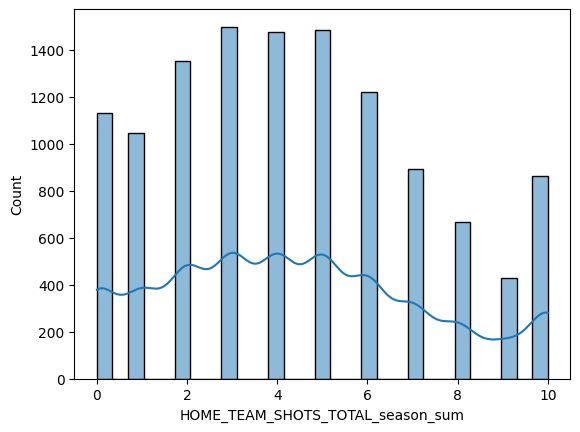

In [10]:
# Example with column = HOME_TEAM_SHOTS_TOTAL_season_sum

# Plot distribution
sns.histplot(df_teamfeatures_train['HOME_TEAM_SHOTS_TOTAL_season_sum'], kde=True)

# Evaluate HOME_TEAM_SHOTS_TOTAL_season_sum that are NaN
print(f"Number of NaN values: {df_teamfeatures_train['HOME_TEAM_SHOTS_TOTAL_season_sum'].isna().sum()}")



#### Plot and save all (train) teamfeatures distributions

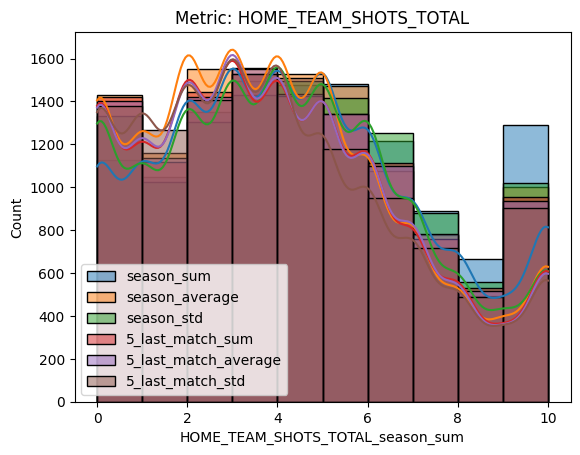

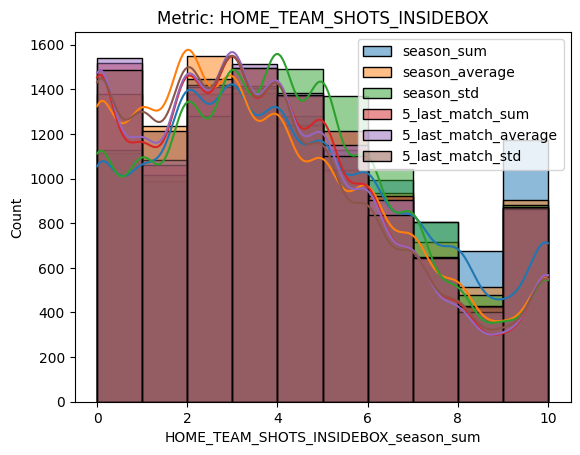

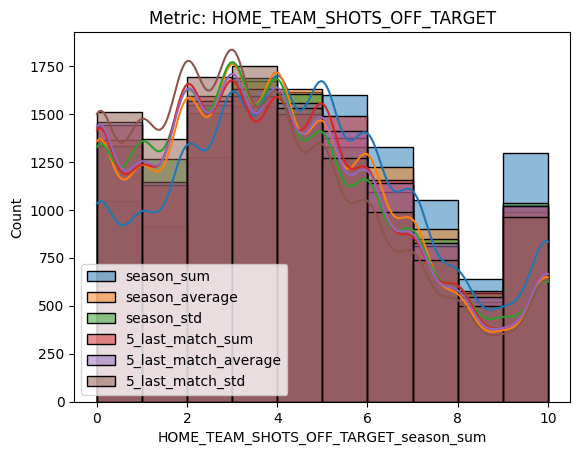

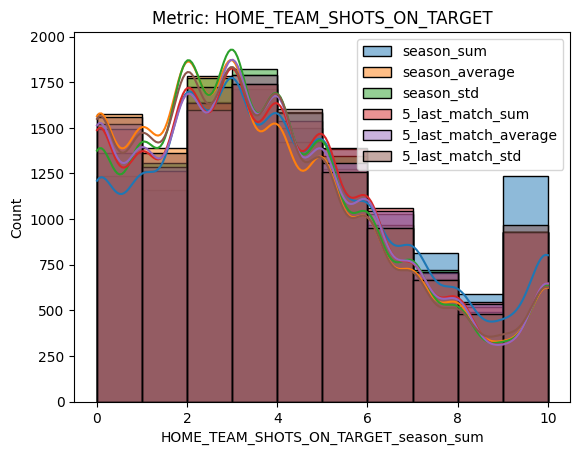

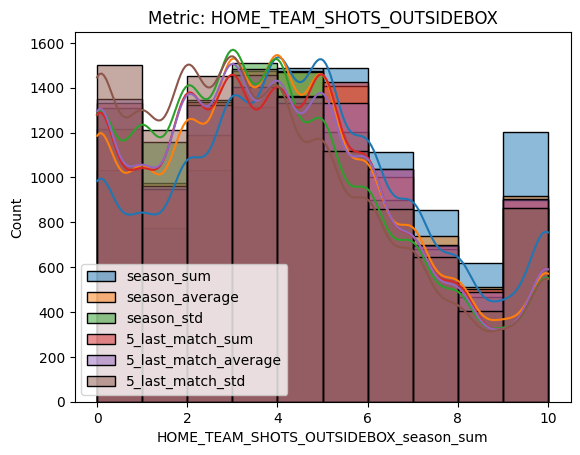

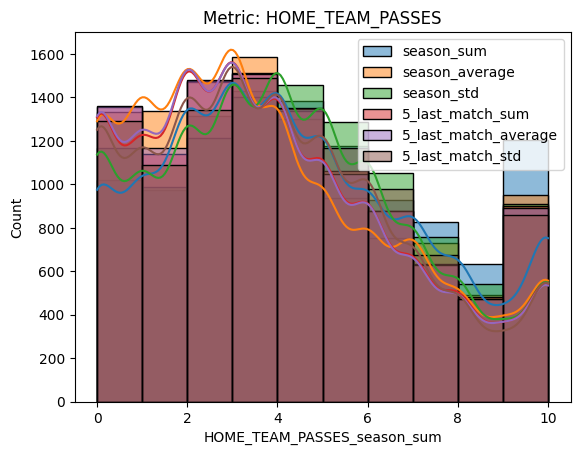

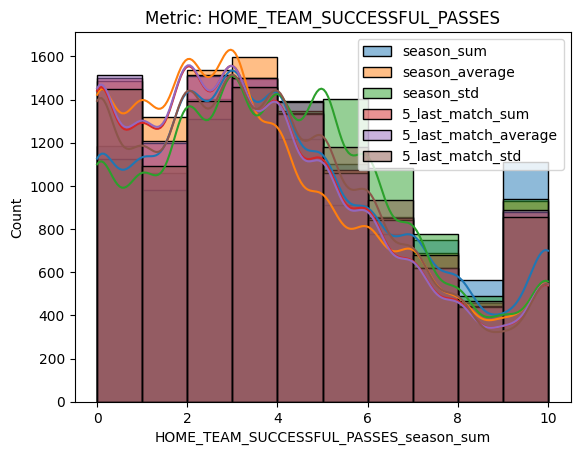

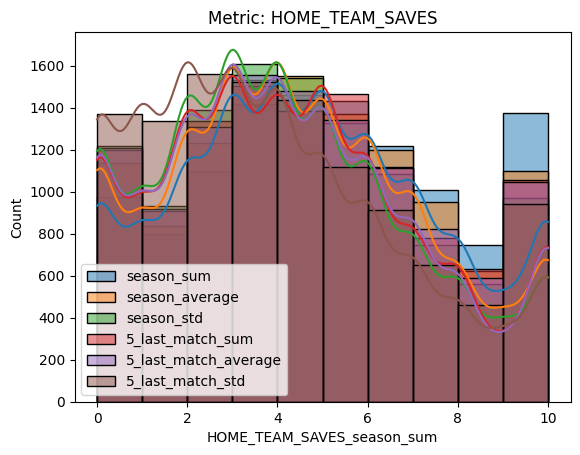

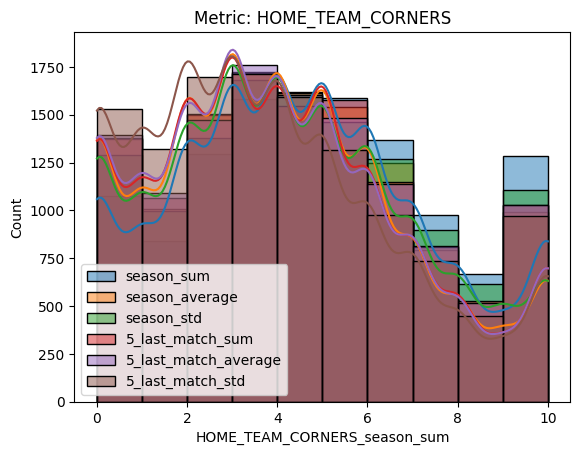

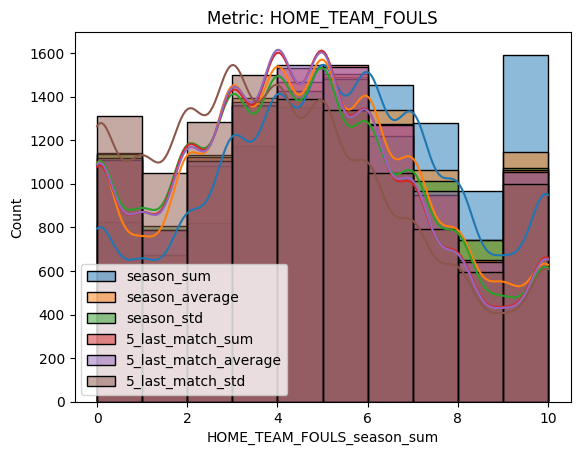

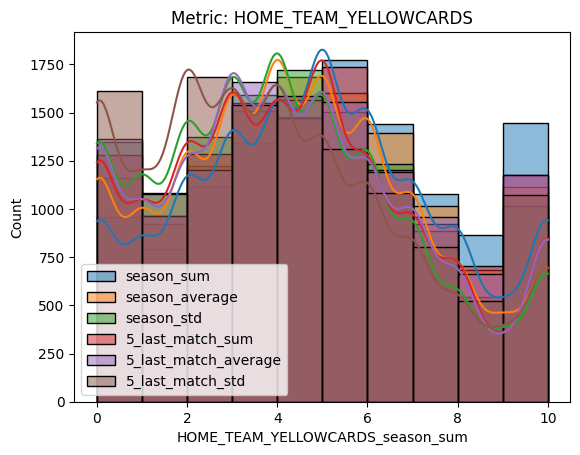

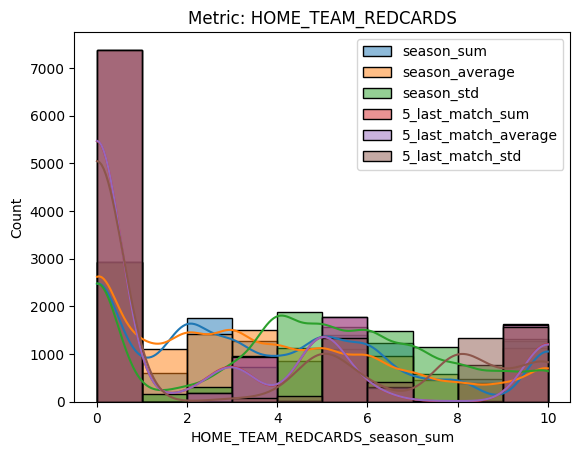

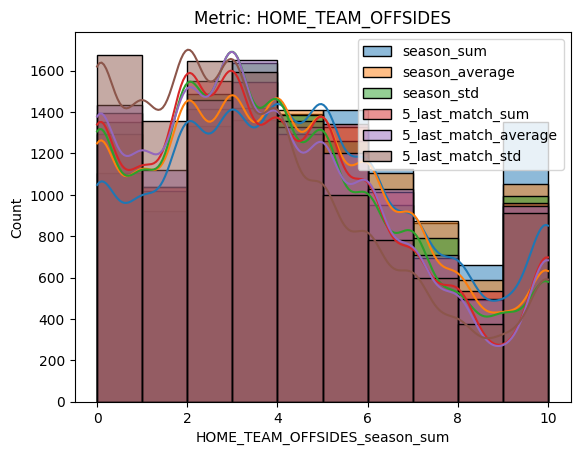

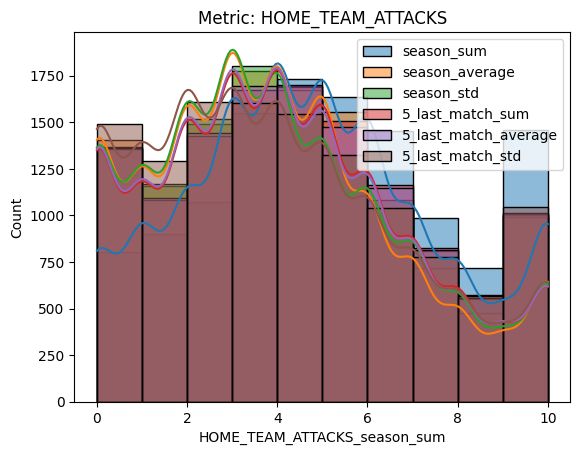

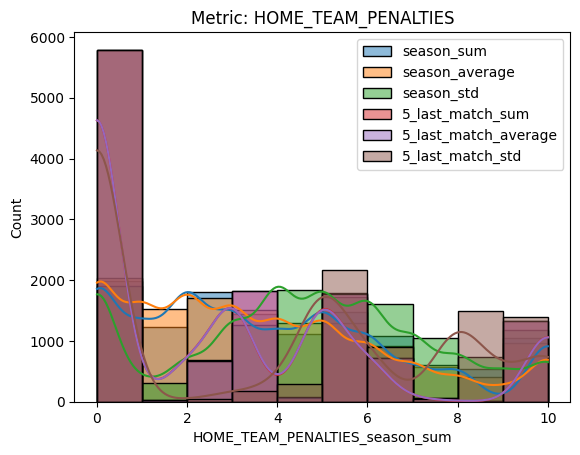

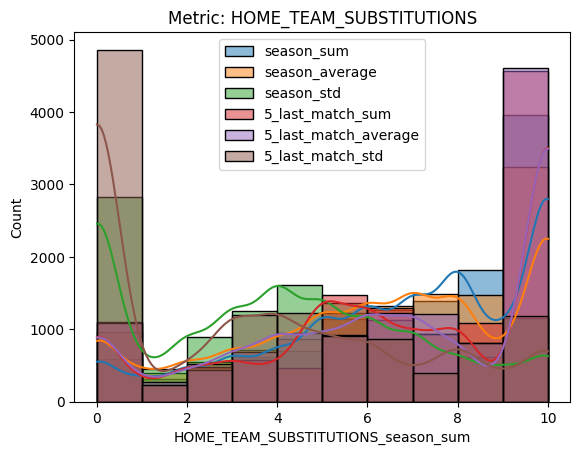

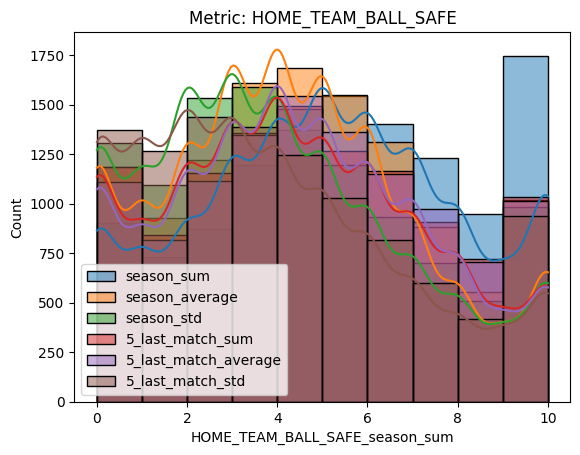

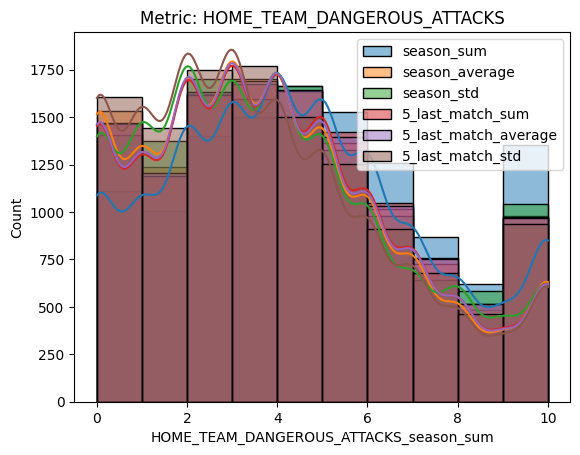

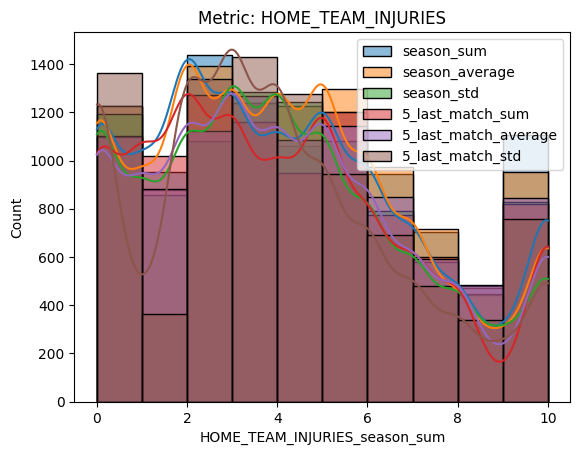

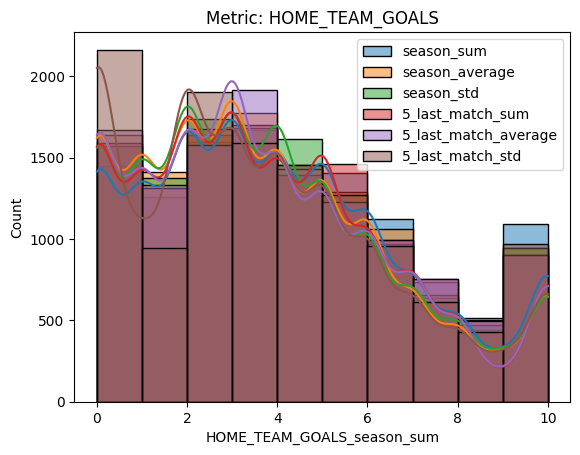

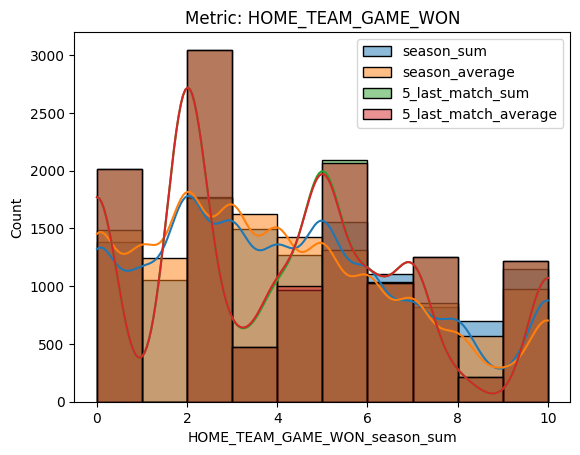

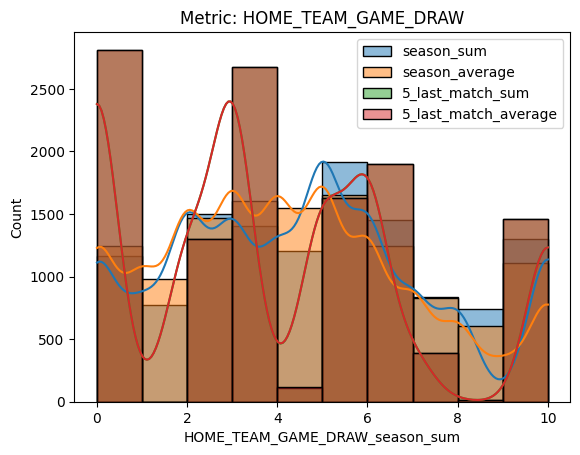

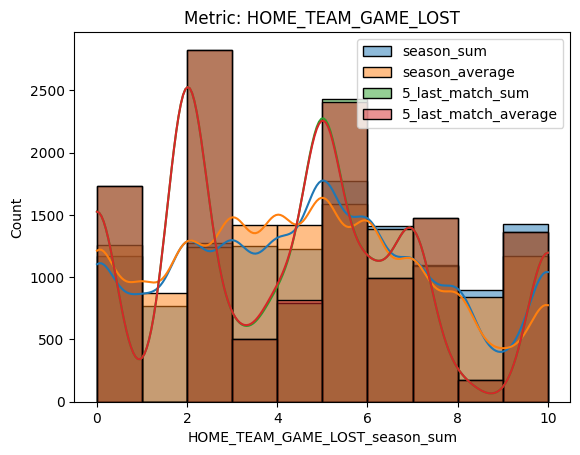

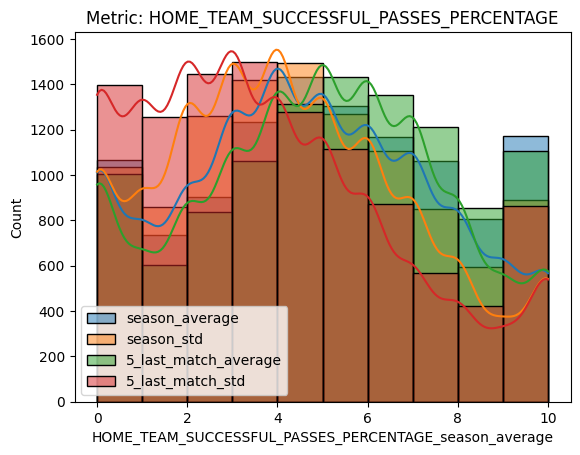

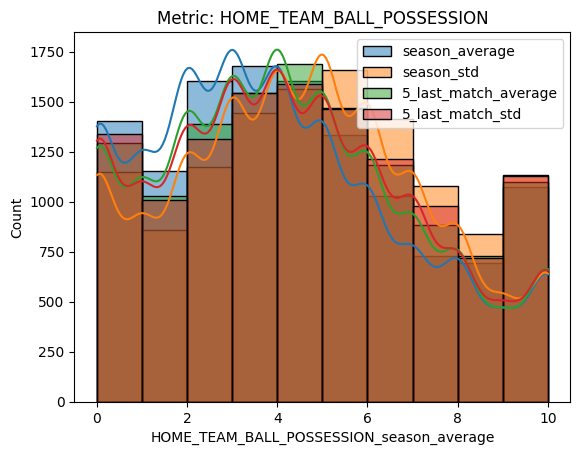

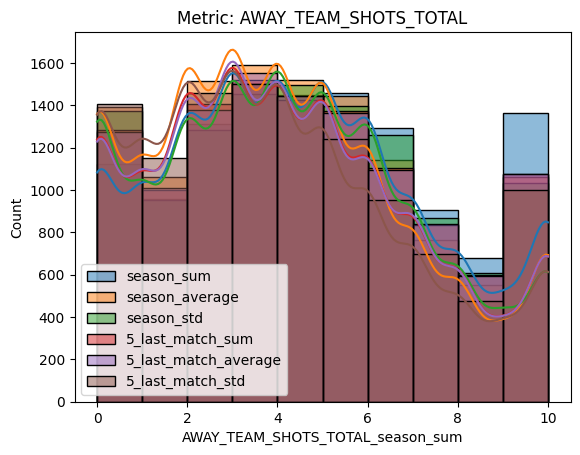

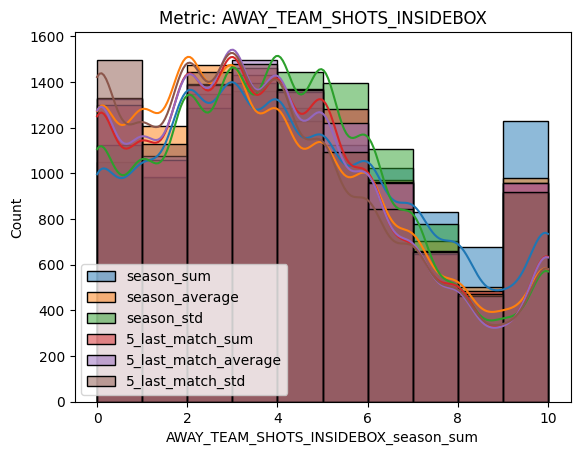

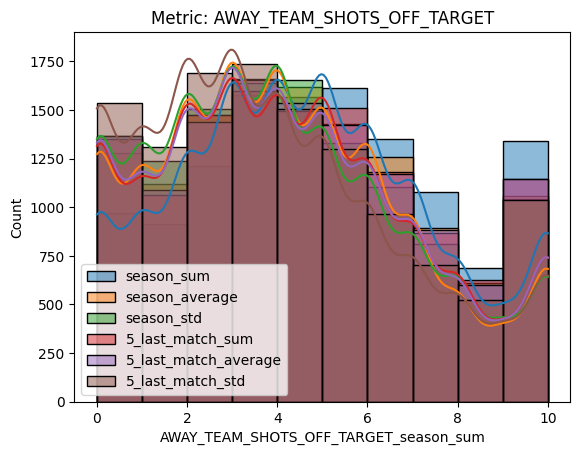

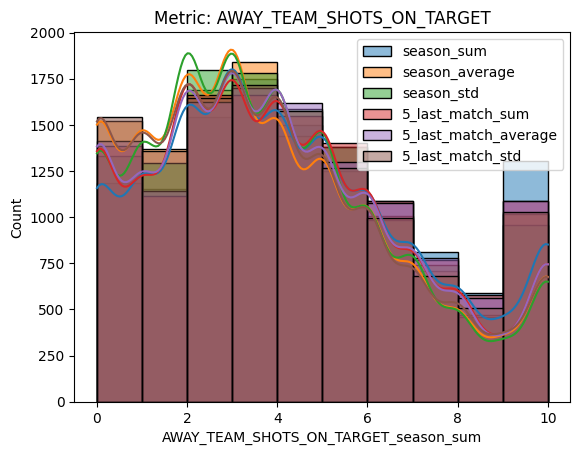

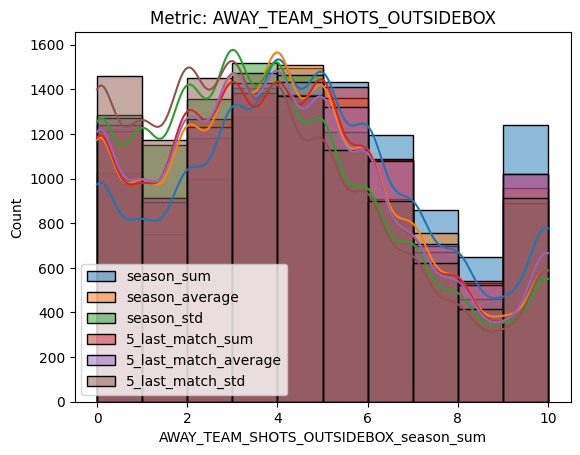

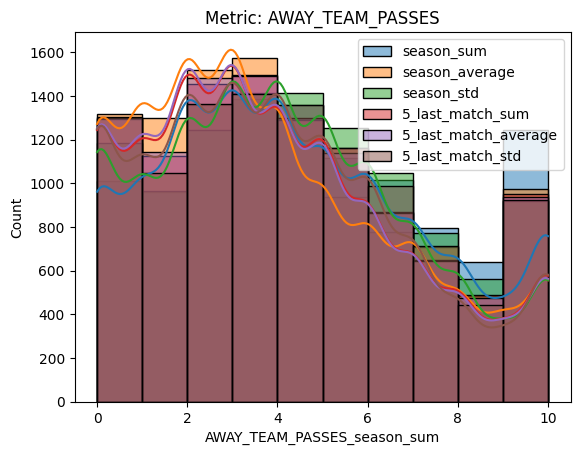

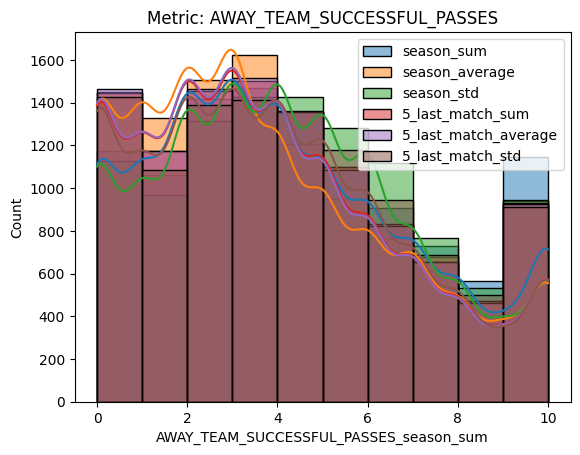

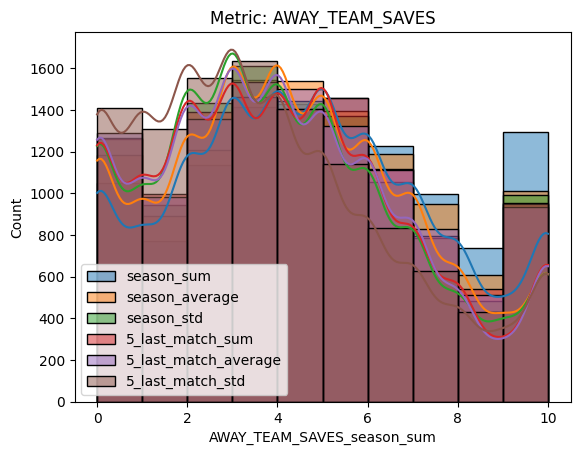

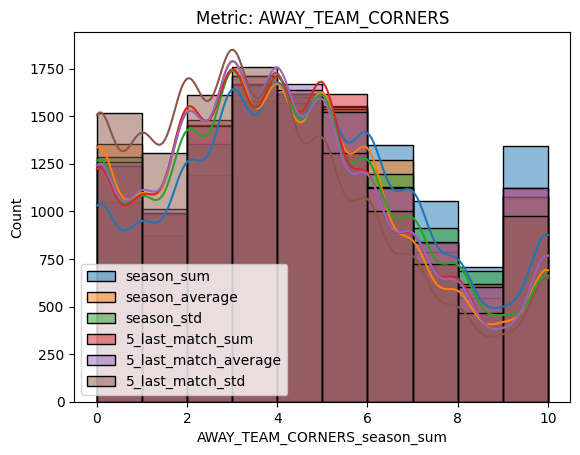

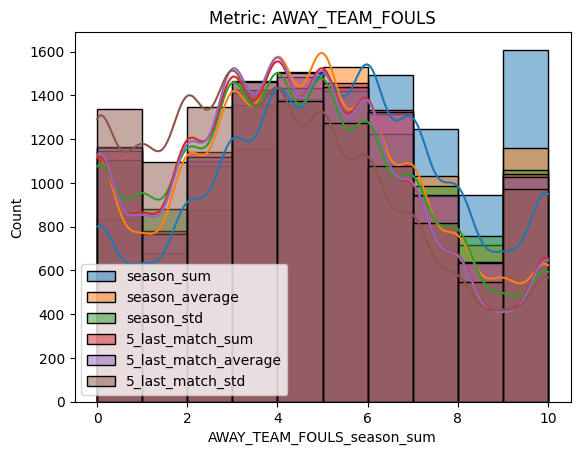

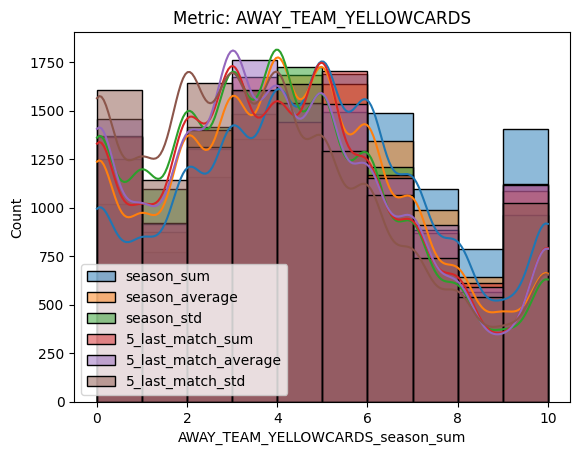

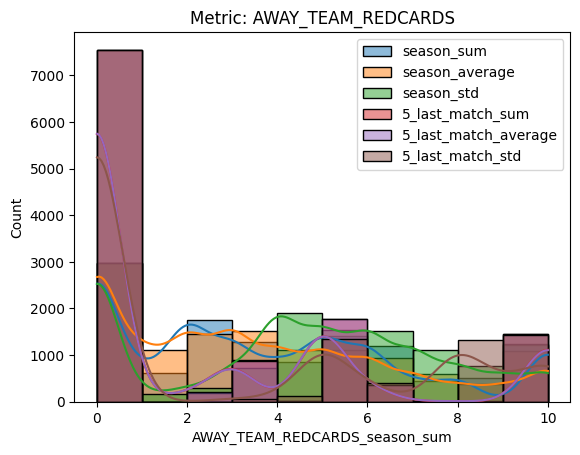

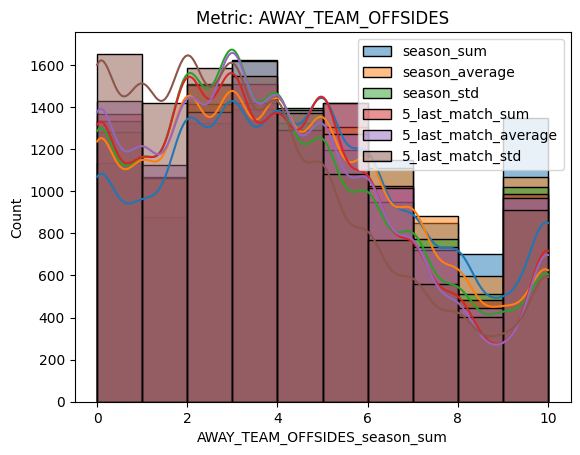

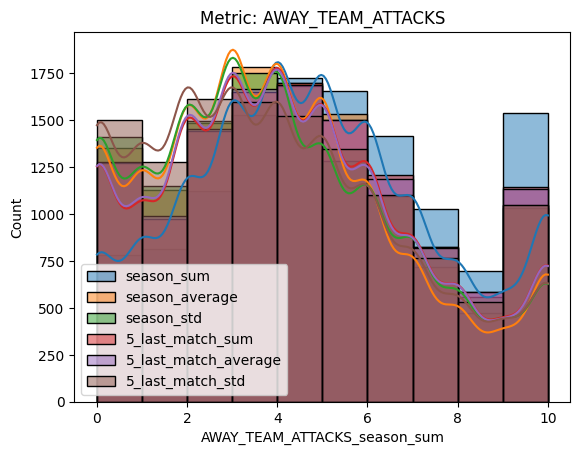

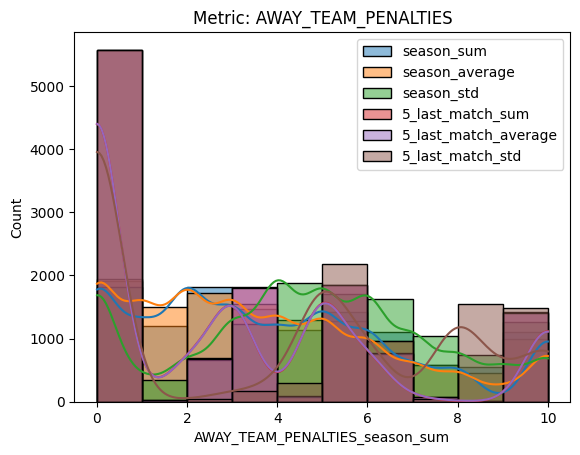

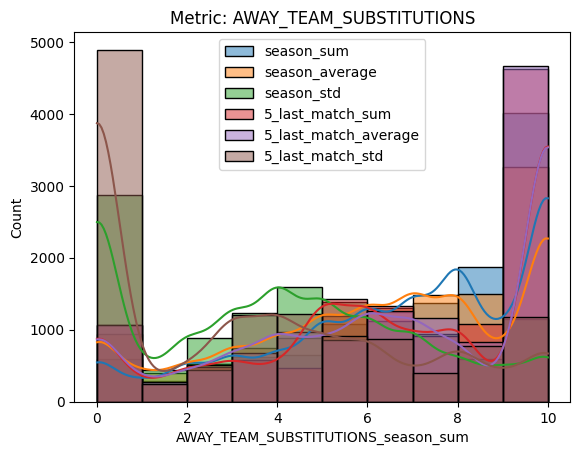

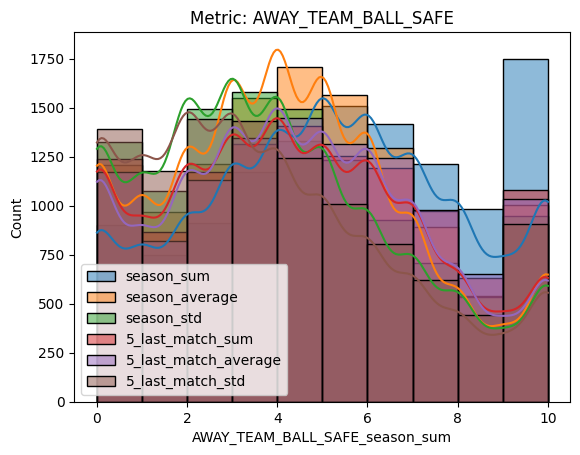

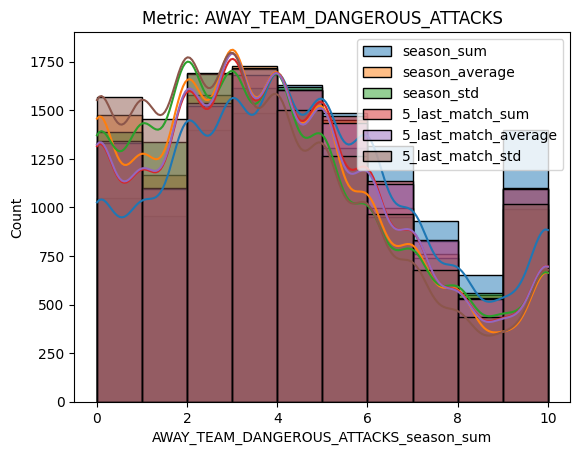

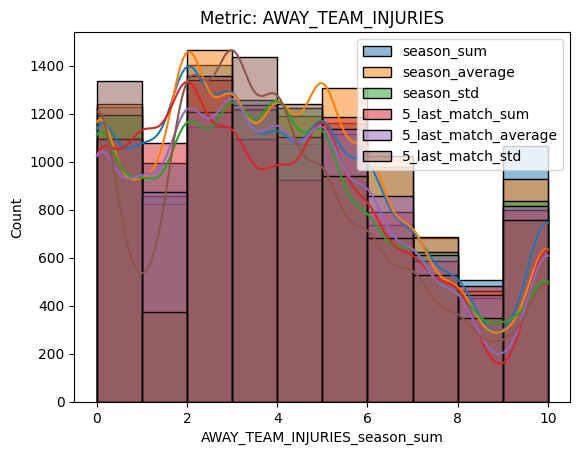

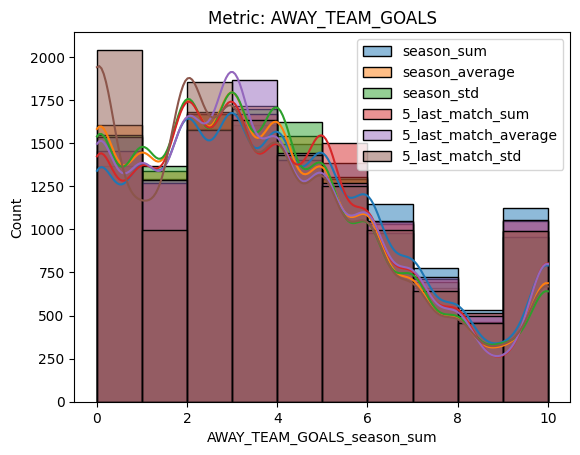

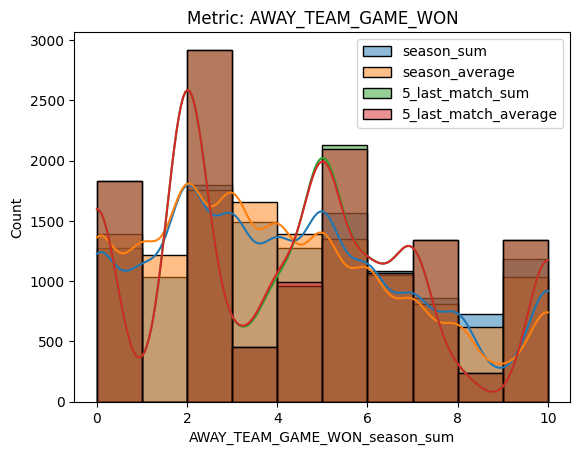

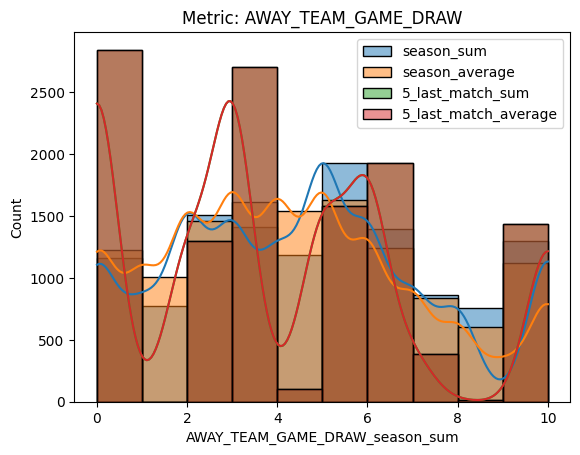

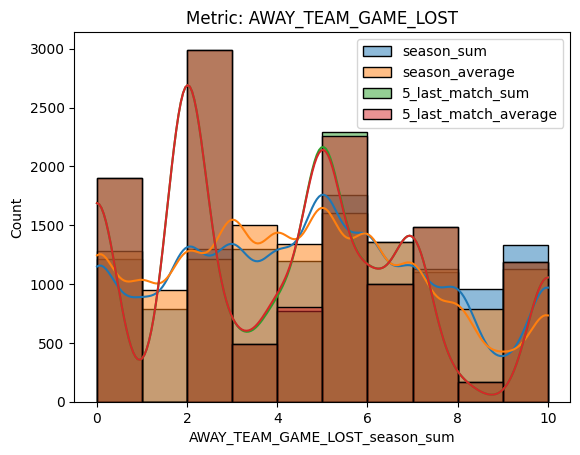

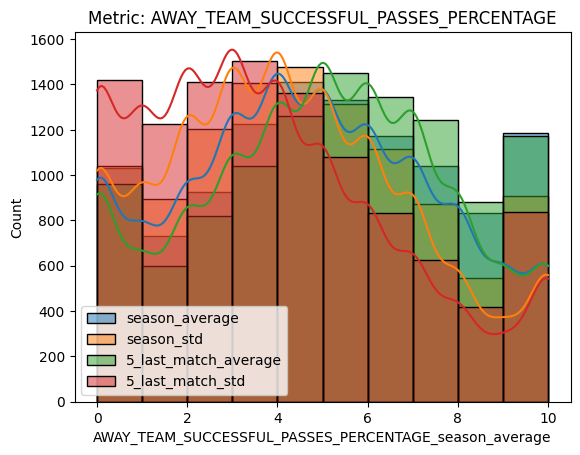

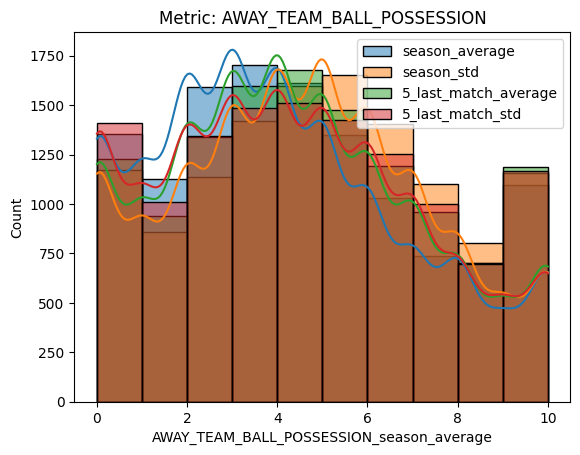

In [10]:
# Save figures of data distribution for every home metric in the train data
for metric_name, aggregate_function_names in teammetrics_names_to_fn_names.items():
    if metric_name in non_aggregated_teammetric_names:
        continue  
    # Plot distributions
    fig, ax = plt.subplots()
    ax.set_title(f"Metric: {metric_name}")
    for aggregate_function_name in aggregate_function_names:
        sns.histplot(df_teamfeatures_train[f"{metric_name}_{aggregate_function_name}"], kde=True, label=aggregate_function_name, bins=10)
    plt.legend()
    plt.show()
    # Save figure
    save_path = f"figures/{metric_name}.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path)

#### Plot and save all (train) playerfeatures distributions

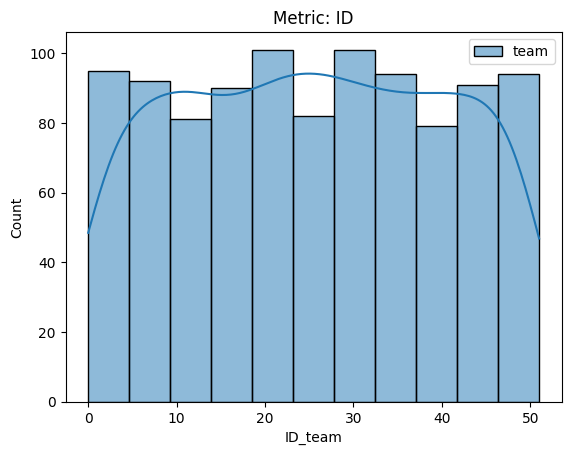

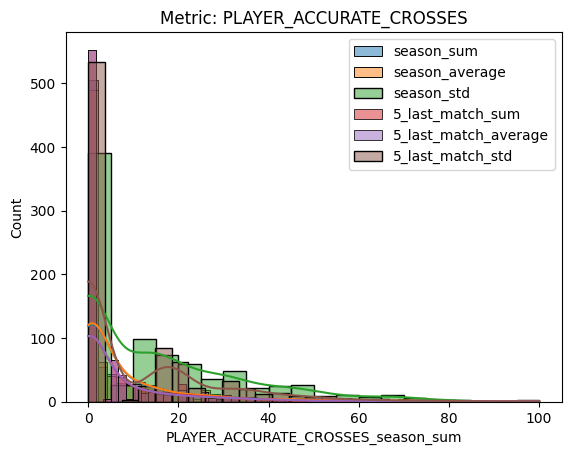

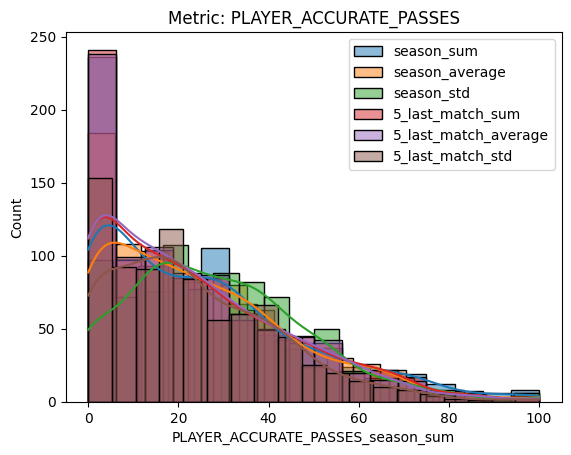

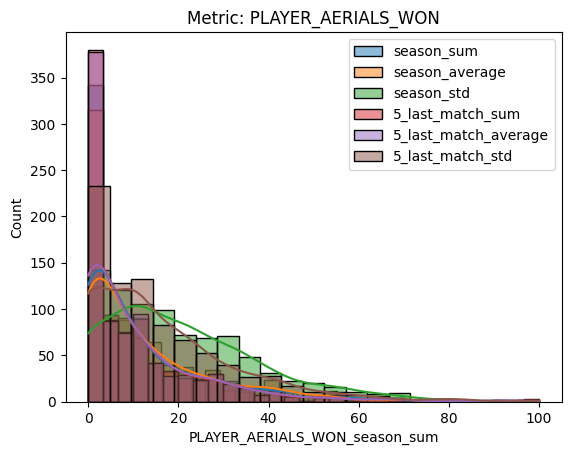

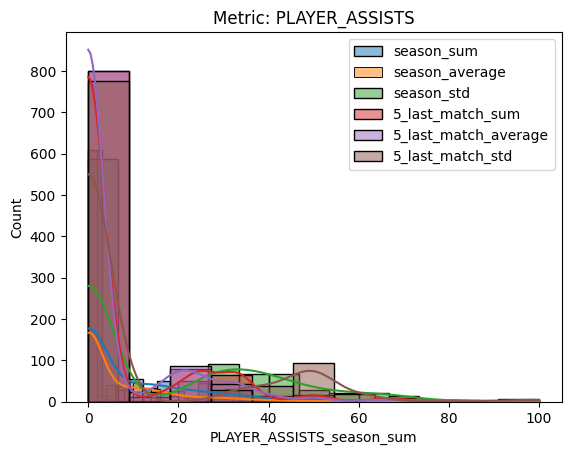

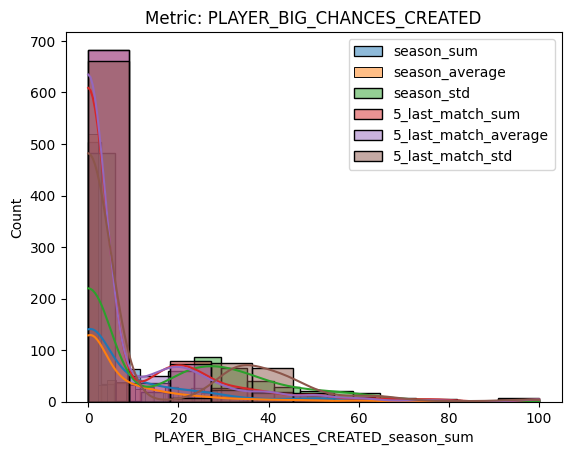

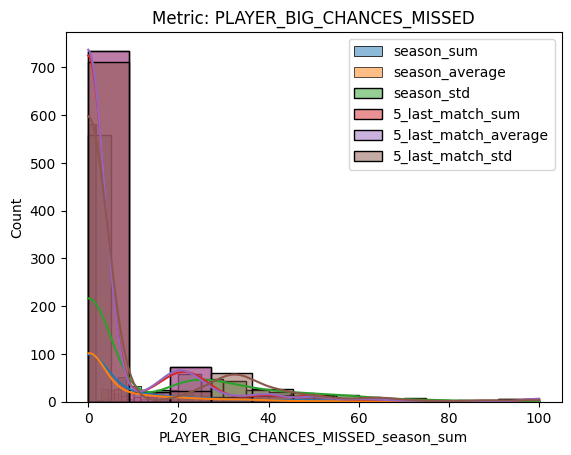

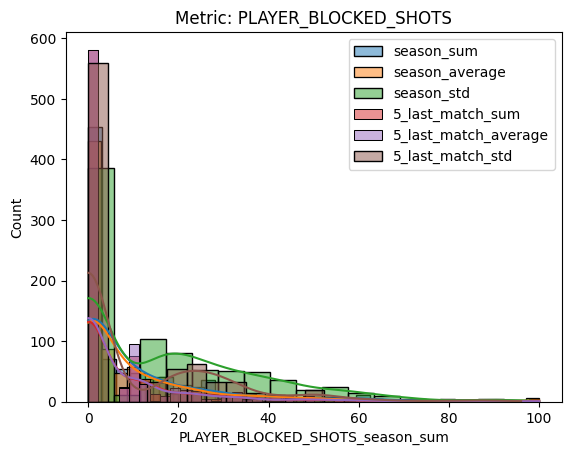

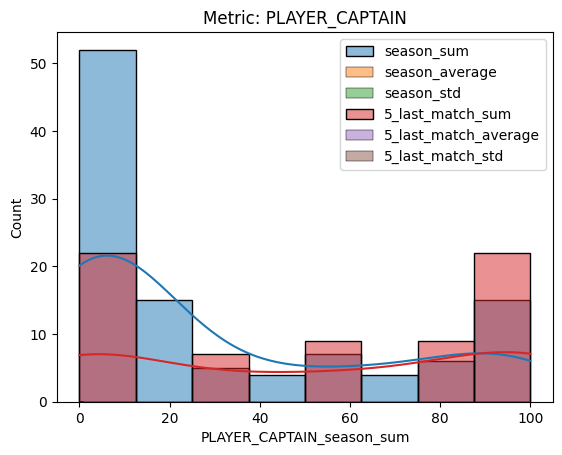

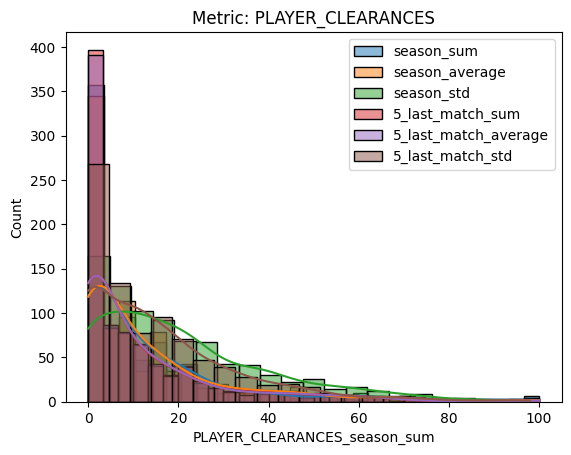

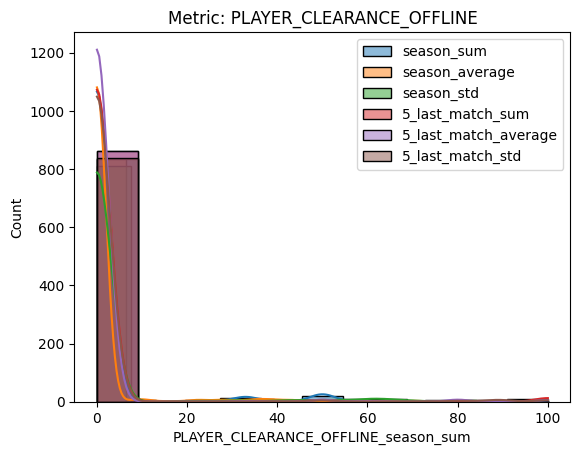

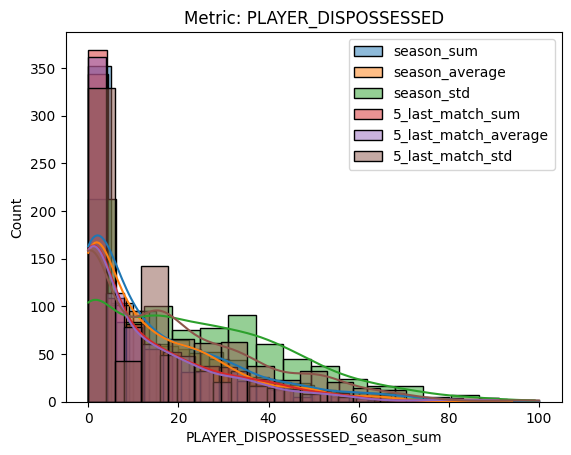

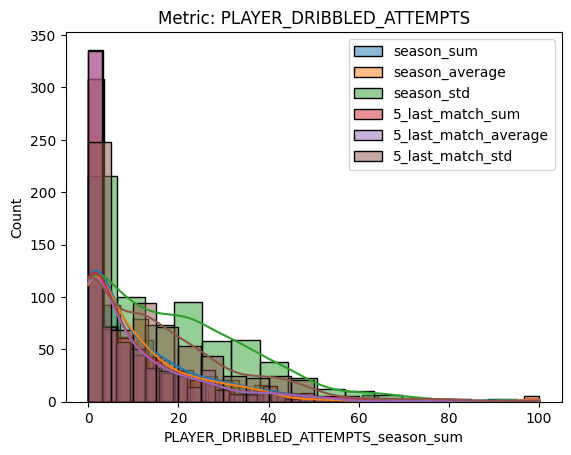

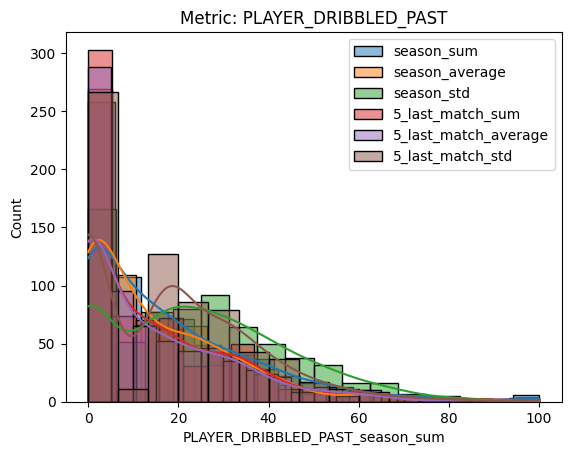

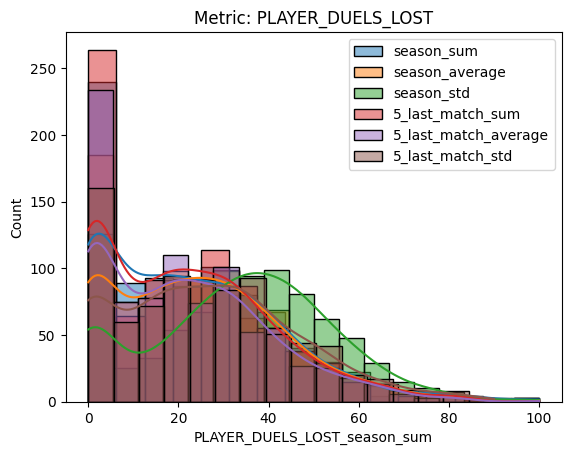

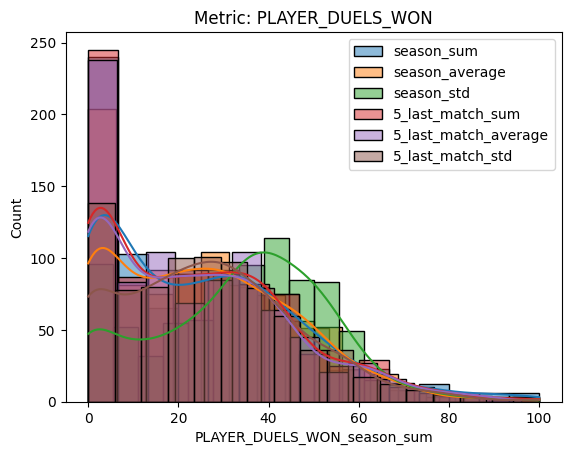

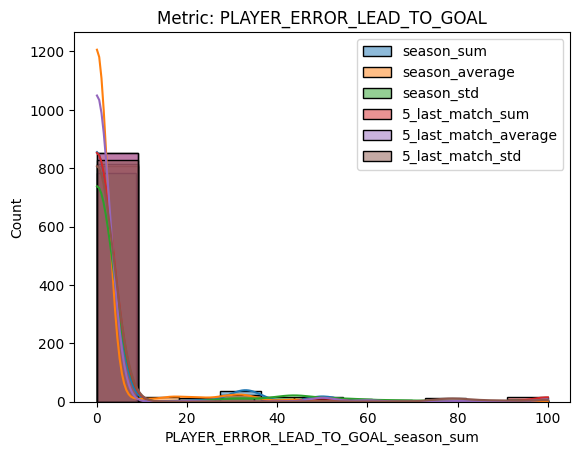

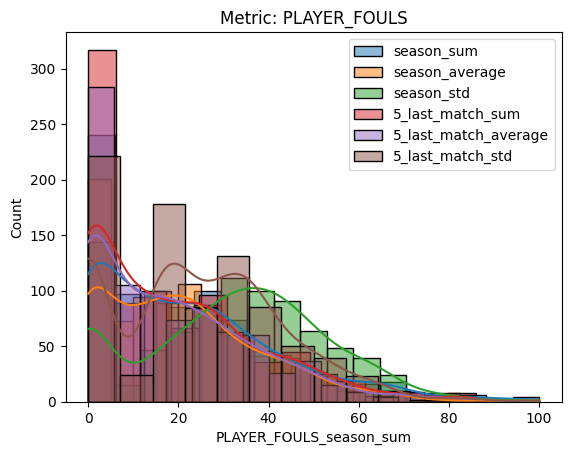

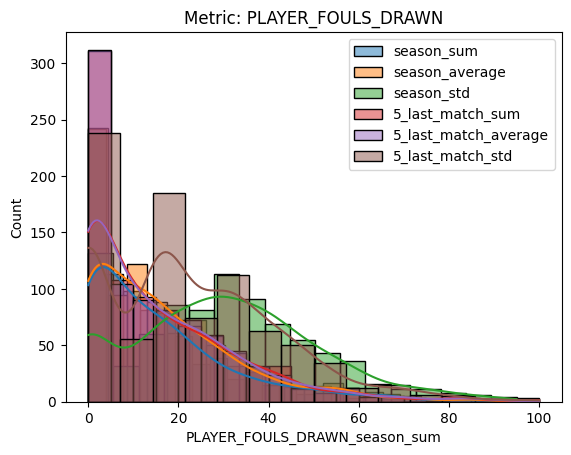

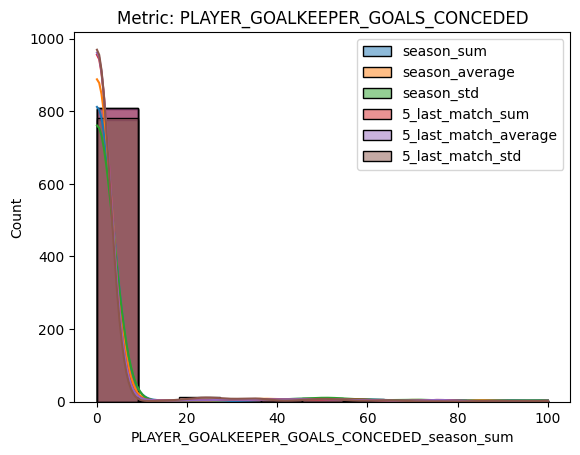

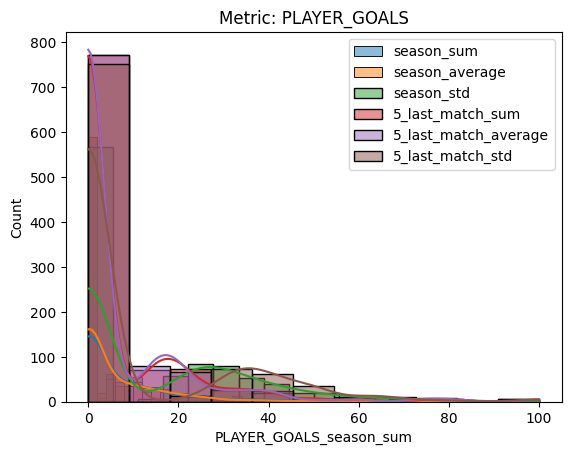

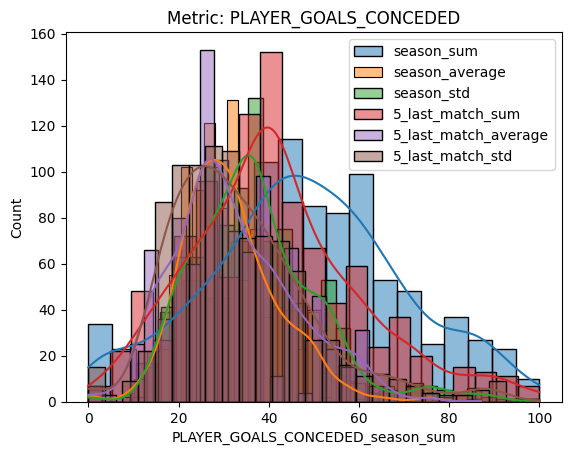

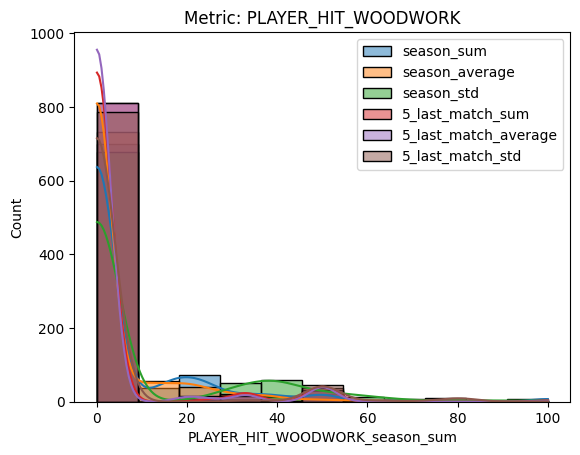

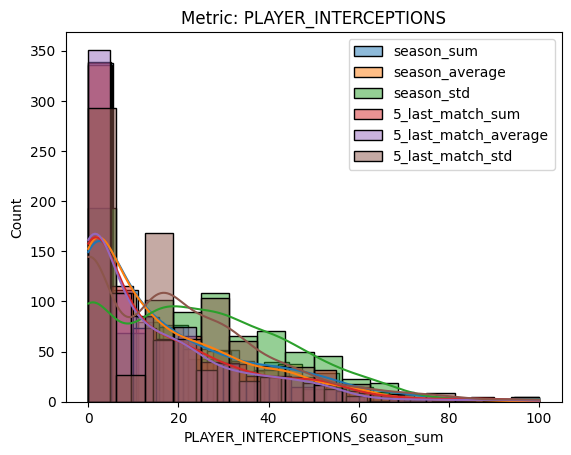

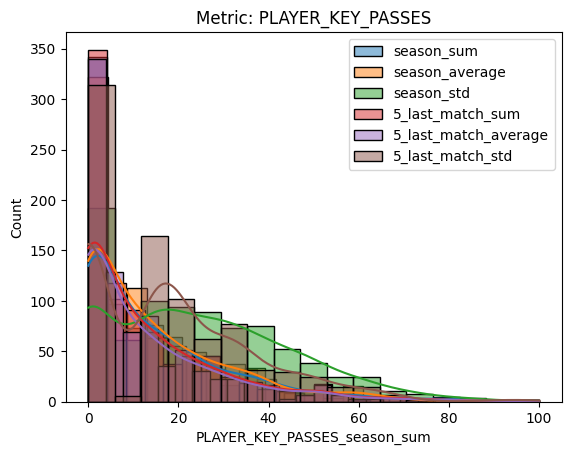

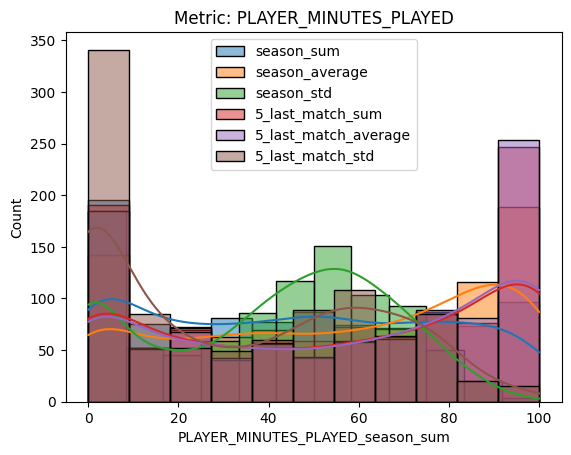

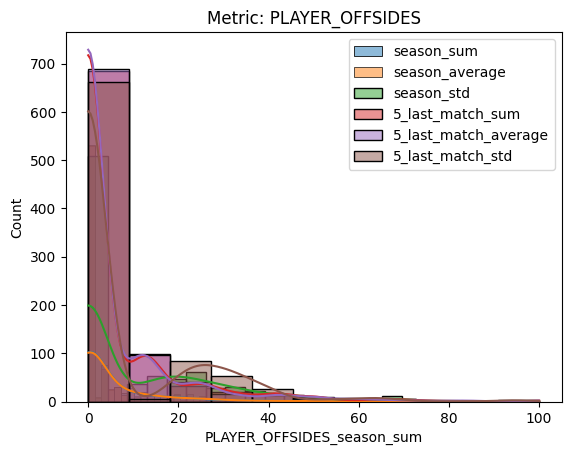

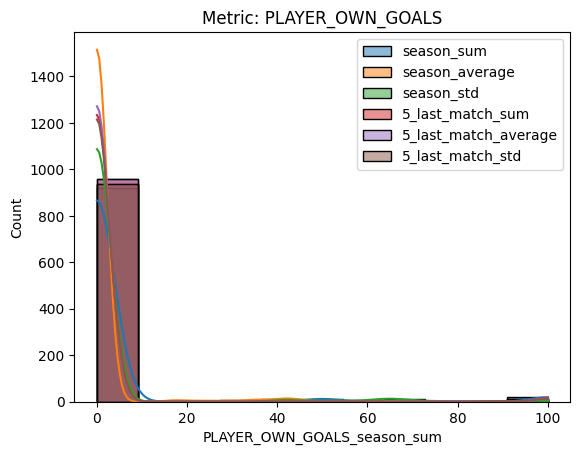

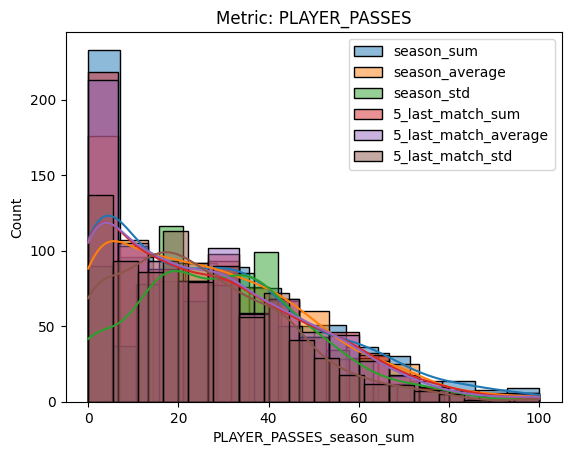

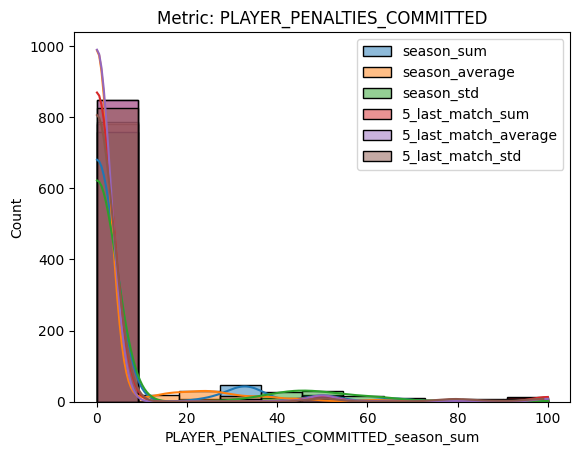

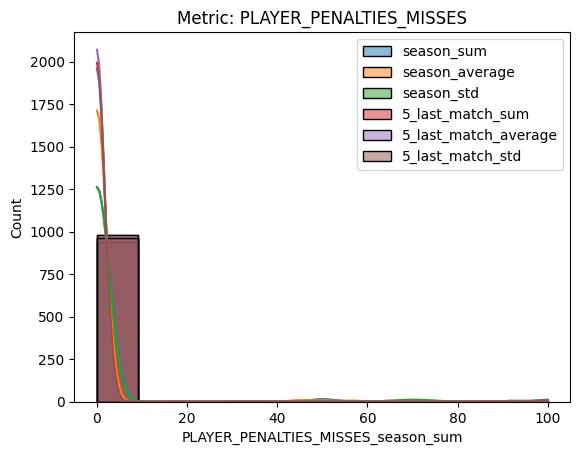

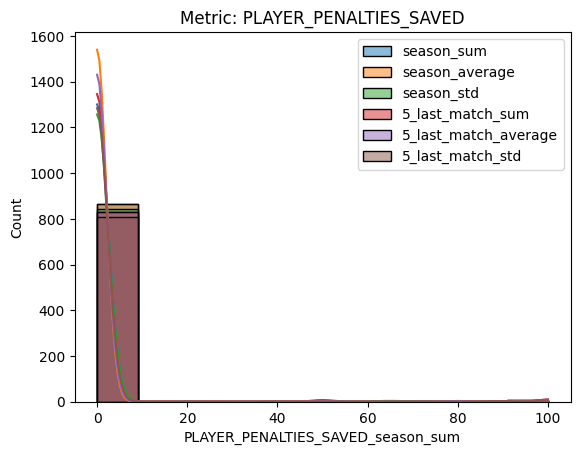

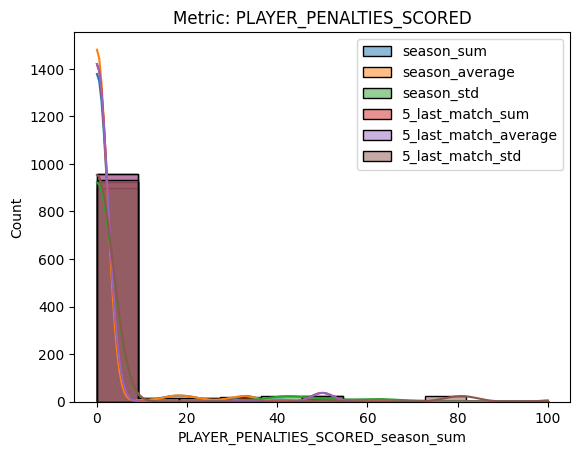

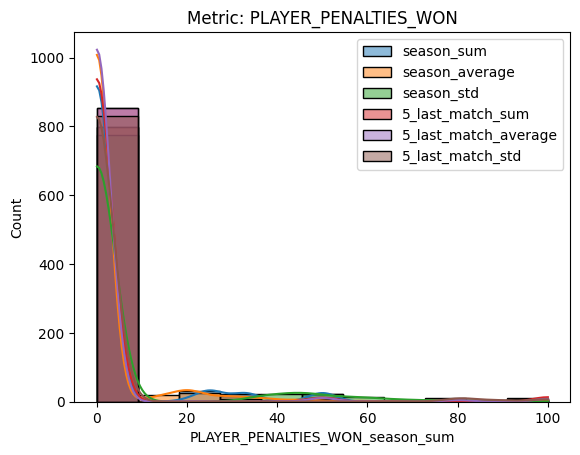

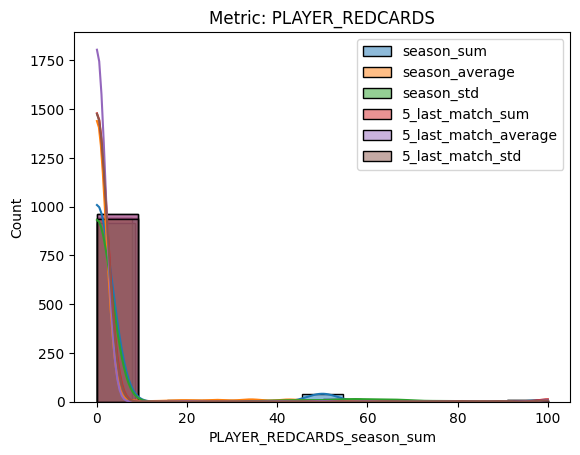

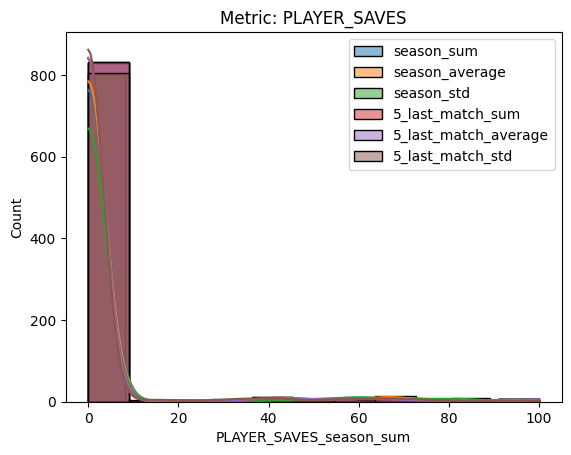

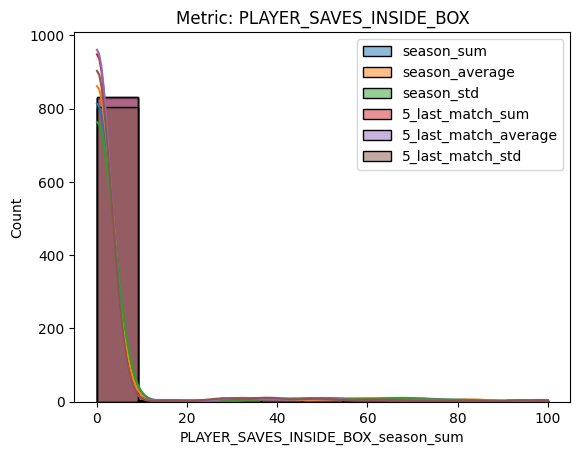

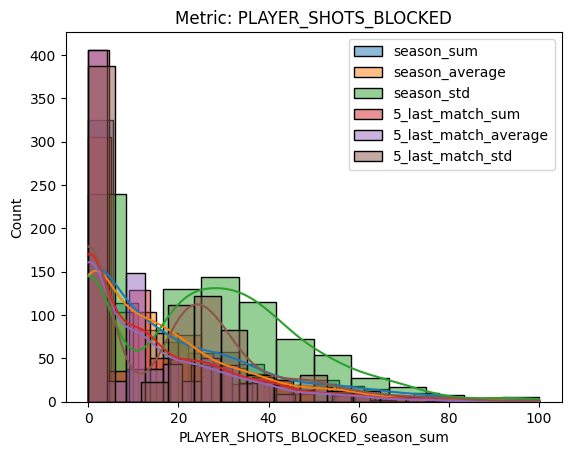

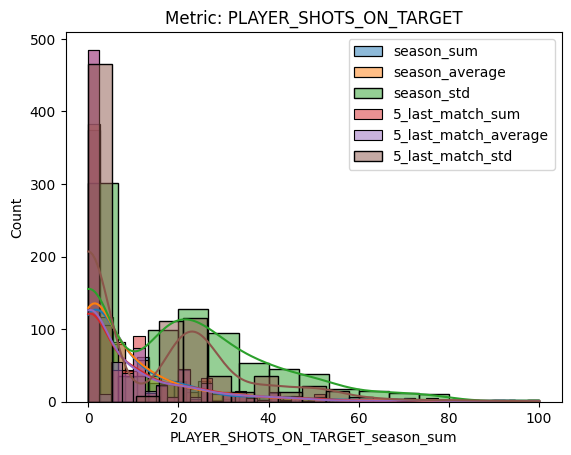

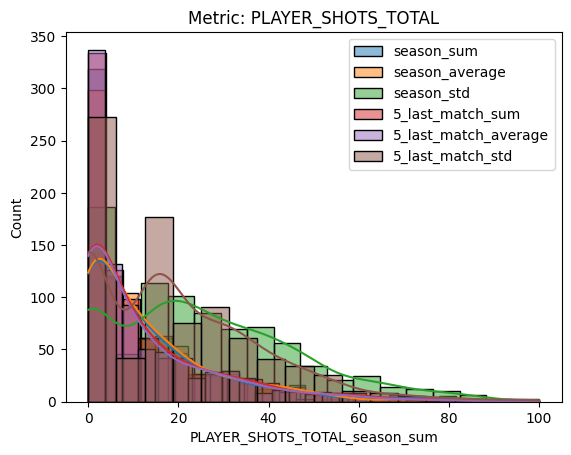

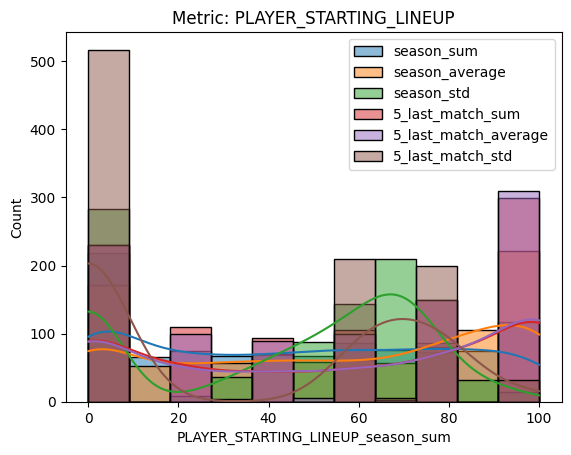

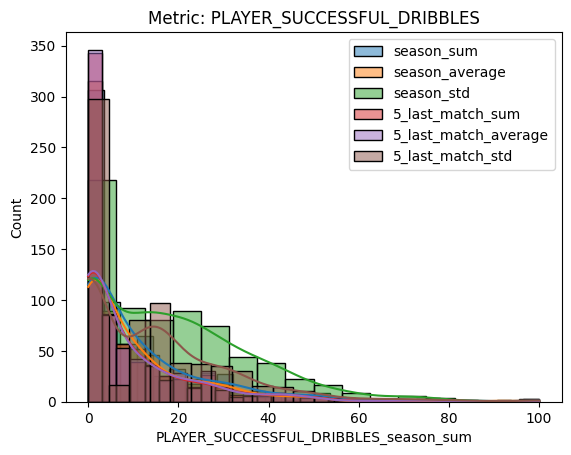

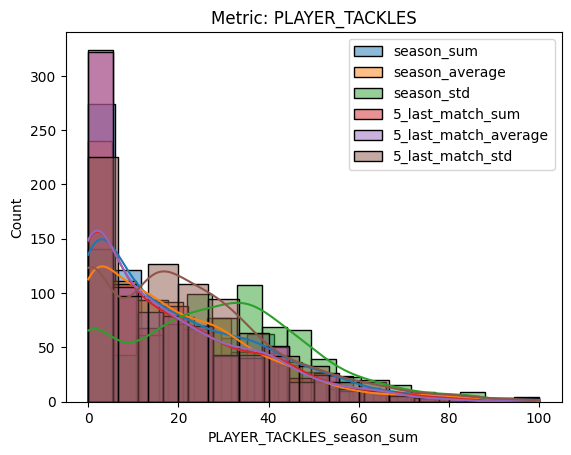

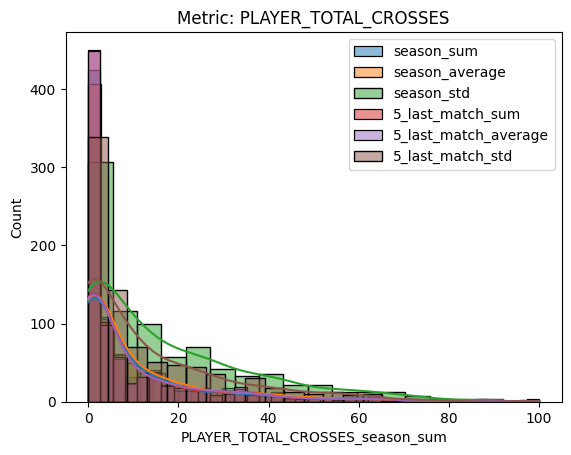

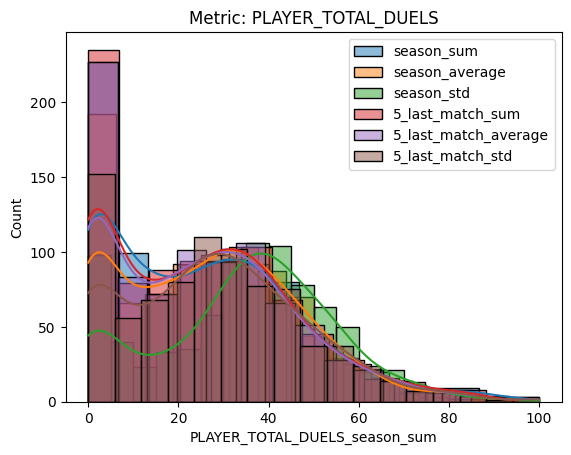

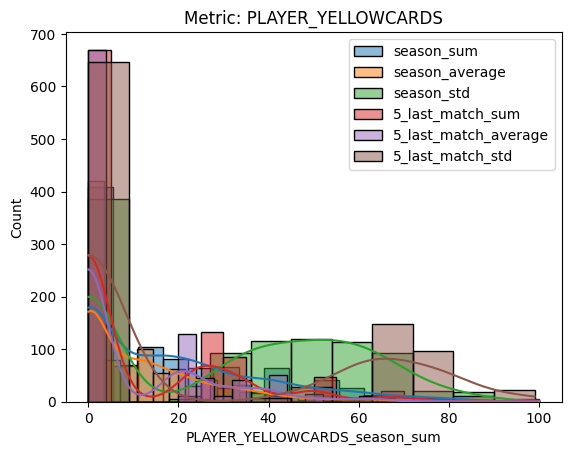

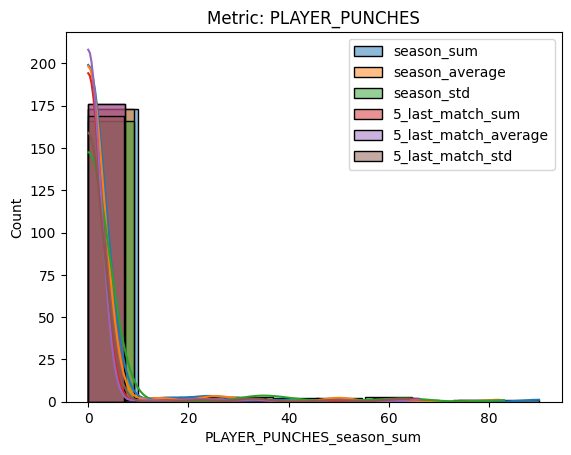

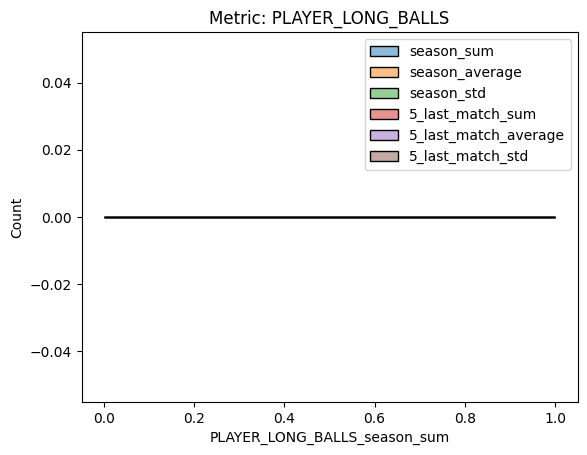

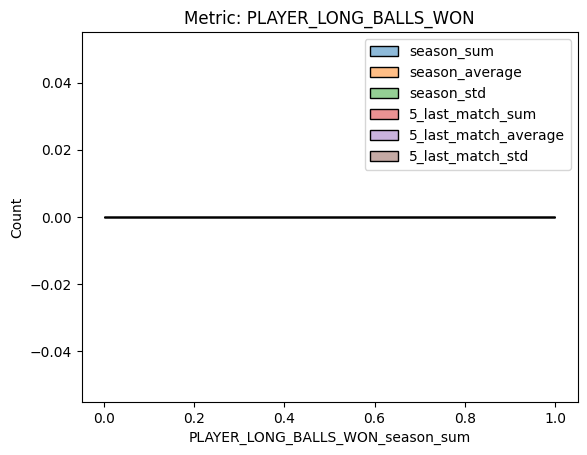

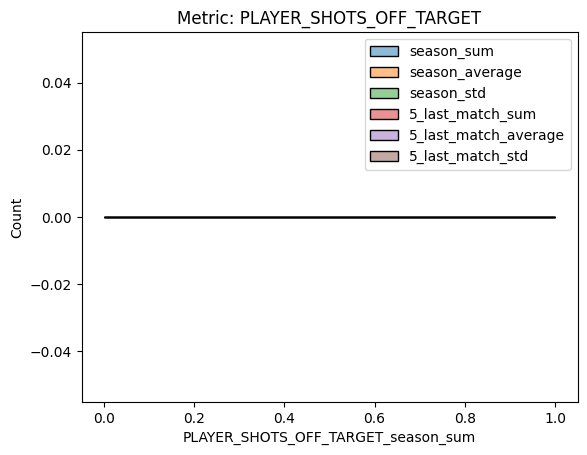

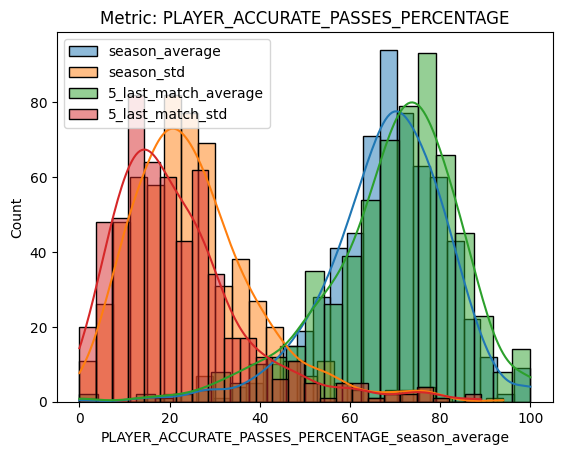

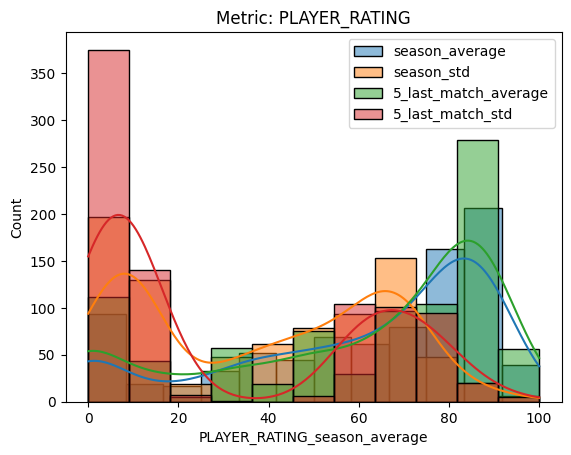

In [15]:
# Save figures of data distribution for every home metric in the train data
for metric_name, aggregate_function_names in playermetrics_names_to_fn_names.items():
    if metric_name in non_aggregated_playermetric_names:
        continue  
    # Plot distributions
    fig, ax = plt.subplots()
    ax.set_title(f"Metric: {metric_name}")
    for aggregate_function_name in aggregate_function_names:
        sns.histplot(df_playersfeatures_train_home[f"{metric_name}_{aggregate_function_name}"], kde=True, label=aggregate_function_name)
    plt.legend()
    plt.show()
    # Save figure
    save_path = f"figures/{metric_name}.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path)

# Comparaison des distributions

## Sum vs Average

Pour une métrique donnée, on a la somme et la moyenne (et d'autres fonctions d'aggrégations). La somme est la somme des valeurs de la métriques pour chaque match de la saison, et la moyenne est la moyenne des valeurs de la feature pour chaque match de la saison. On remarque que la somme et la moyenne ne sont pas proportionelle dans les données.

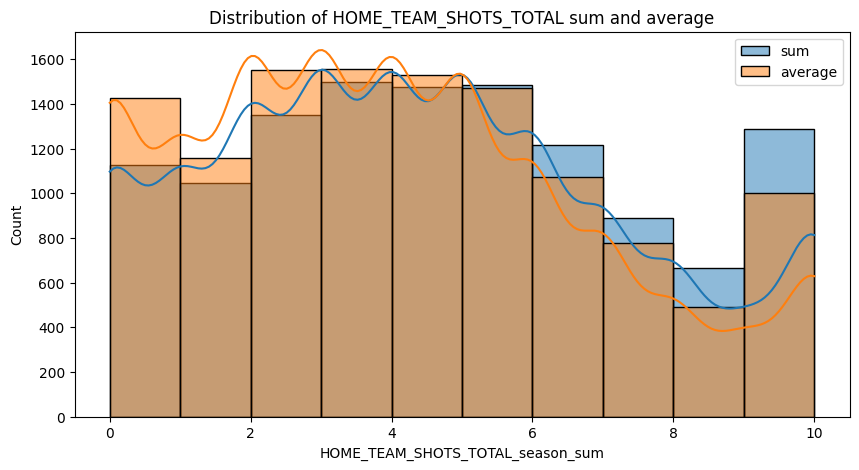

Number of NaN values for HOME_TEAM_SHOTS_TOTAL sum: 260
Number of NaN values for HOME_TEAM_SHOTS_TOTAL average: 260


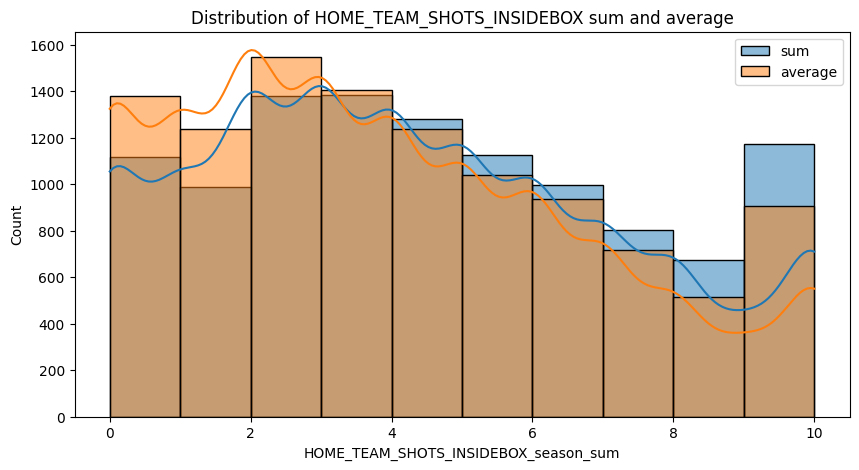

Number of NaN values for HOME_TEAM_SHOTS_INSIDEBOX sum: 1385
Number of NaN values for HOME_TEAM_SHOTS_INSIDEBOX average: 1385


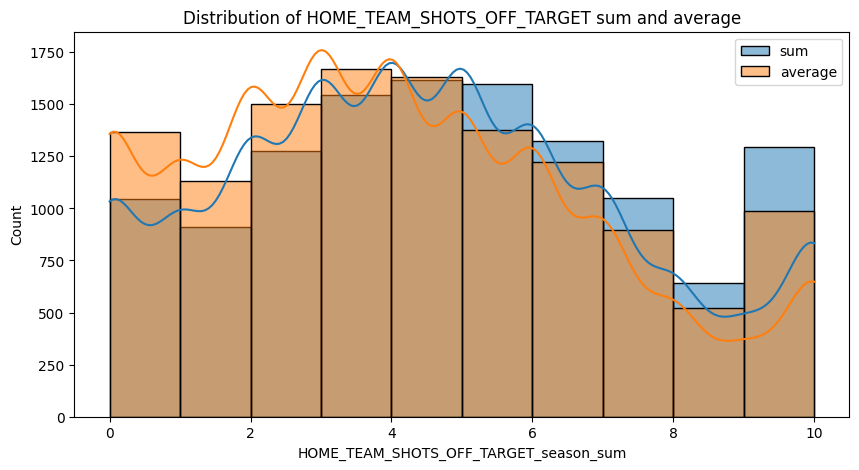

Number of NaN values for HOME_TEAM_SHOTS_OFF_TARGET sum: 0
Number of NaN values for HOME_TEAM_SHOTS_OFF_TARGET average: 0


In [11]:
# Comparison of the distribution of an averaged metric and the sum of the same metric on 3 examples
for metric_name in [metric_name for metric_name in teammetrics_names_to_fn_names.keys() if metric_name not in non_aggregated_teammetric_names][:3]:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_teamfeatures_train[f'{metric_name}_season_sum'], kde=True, label='sum', bins=10)
    sns.histplot(df_teamfeatures_train[f'{metric_name}_season_average'], kde=True, label='average', bins=10)
    plt.title(f"Distribution of {metric_name} sum and average")
    plt.legend()
    plt.show()
    
    # Compute the number of NaN values for the sum and average
    n_nan_sum = df_teamfeatures_train[f'{metric_name}_season_sum'].isna().sum()
    n_nan_average = df_teamfeatures_train[f'{metric_name}_season_average'].isna().sum()
    print(f"Number of NaN values for {metric_name} sum: {n_nan_sum}")
    print(f"Number of NaN values for {metric_name} average: {n_nan_average}")



## Sum vs Average on the last 5 matches

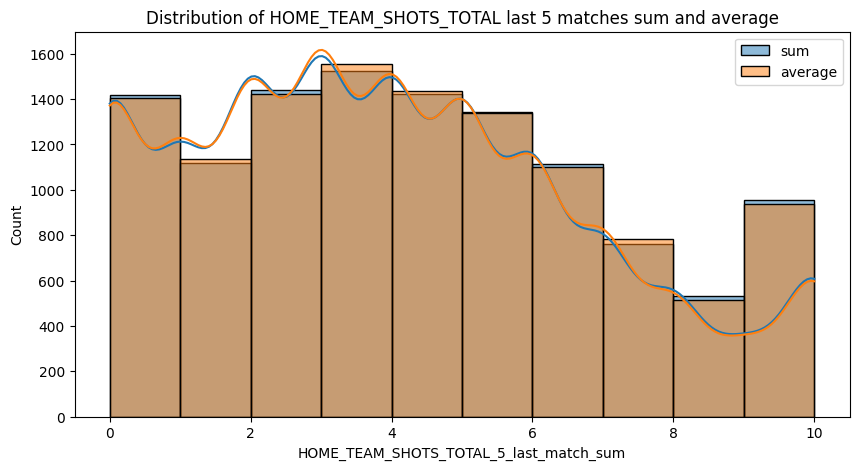

Number of NaN values for HOME_TEAM_SHOTS_TOTAL sum: 675
Number of NaN values for HOME_TEAM_SHOTS_TOTAL average: 675


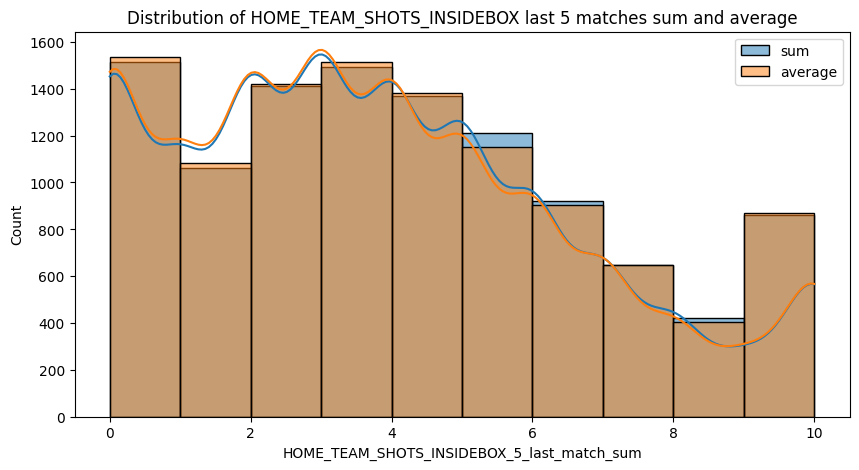

Number of NaN values for HOME_TEAM_SHOTS_INSIDEBOX sum: 1388
Number of NaN values for HOME_TEAM_SHOTS_INSIDEBOX average: 1388


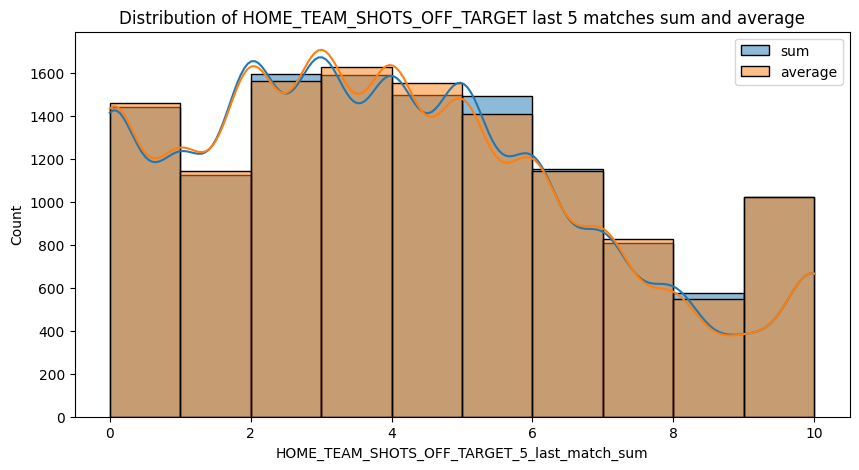

Number of NaN values for HOME_TEAM_SHOTS_OFF_TARGET sum: 0
Number of NaN values for HOME_TEAM_SHOTS_OFF_TARGET average: 0


In [9]:
# Comparison of the distribution of an averaged metric and the sum of the same metric on 3 examples
from src.data_analysis import non_aggregated_teammetric_names, non_aggregated_playermetric_names, get_metrics_names_to_fn_names
from src.data_loading import load_dataframe_teamfeatures, load_dataframe_playersfeatures
import seaborn as sns
import matplotlib.pyplot as plt
 
df_teamfeatures_train = load_dataframe_teamfeatures(dataset_prefix='train')
teammetrics_names_to_fn_names = get_metrics_names_to_fn_names(df_teamfeatures_train)
for metric_name in [metric_name for metric_name in teammetrics_names_to_fn_names.keys() if metric_name not in non_aggregated_teammetric_names][:3]:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_teamfeatures_train[f'{metric_name}_5_last_match_sum'], kde=True, label='sum', bins=10)
    sns.histplot(df_teamfeatures_train[f'{metric_name}_5_last_match_average'], kde=True, label='average', bins=10)
    plt.title(f"Distribution of {metric_name} last 5 matches sum and average")
    plt.legend()
    plt.show()
    
    # Compute the number of NaN values for the sum and average
    n_nan_sum = df_teamfeatures_train[f'{metric_name}_5_last_match_sum'].isna().sum()
    n_nan_average = df_teamfeatures_train[f'{metric_name}_5_last_match_average'].isna().sum()
    print(f"Number of NaN values for {metric_name} sum: {n_nan_sum}")
    print(f"Number of NaN values for {metric_name} average: {n_nan_average}")

